In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
import matplotlib.cm as cm
from datetime import datetime
from openpyxl import load_workbook
from openpyxl.styles import PatternFill, Font
from openpyxl.utils.dataframe import dataframe_to_rows
import os

# **1. Data Importing,Cleaning and Sorting**

In [4]:
hf_df = pd.read_excel("Data/hedge_funds_returns_data.xlsx")

In [5]:
short_mapping = {
    'Date': 'Date',
    'HFRI 400 (US) Fund Weighted Composite Index (HFRI4FWC)': 'HFRI4FWC',
    'HFRI 400 (US) EH: Long/Short Index (HFRI4ELS)': 'HFRI4ELS',
    'HFRI 400 (US) EH: Fundamental Value Index (HFRI4EHV)': 'HFRI4EHV',
    'HFRI 400 (US) Event-Driven Index (HFRI4ED)': 'HFRI4ED'
    
}

hf_df = hf_df.rename(columns=short_mapping)
hf_df.head()

,Date,HFRI4FWC,HFRI4ELS,HFRI4ED,HFRI4EHV
0,2005-01-31,0.0047,0.0067,0.0012,0.0049
1,2005-02-28,0.0198,0.0279,0.0111,0.0219
2,2005-03-31,-0.0103,-0.0172,0.0002,-0.0111
3,2005-04-29,-0.0124,-0.0165,-0.0105,-0.0137
4,2005-05-31,0.0079,0.0122,0.0064,0.0122


In [6]:
def clean_data(df):
    df = df.set_index('Date')
    df = df.dropna()
    df.index = pd.to_datetime(df.index)
    df = df.sort_index()
    return df
    
hf_df = clean_data(hf_df)

In [7]:
def check_dataframe_info(df, name):
    print(f"\n=== {name} INFO ===")
    print(f"Shape: {df.shape}")
    print(f"Date range: {df.index.min()} to {df.index.max()}")
    print(f"Total NaN values: {df.isnull().sum().sum()}")
    print(f"Index is sorted: {df.index.is_monotonic_increasing}")
    print(f"Index type: {type(df.index)}")
    print("\nNaN values per column:")
    print(df.isnull().sum())
    print("\nFirst 2 rows:")
    print(df.head(2))
    print("\nLast 2 rows:")
    print(df.tail(2))

def check_alignment(df1, name1):
    print(f"\n=== ALIGNMENT CHECK ===")
    print(f"{name1} date range: {df1.index.min()} to {df1.index.max()}")
    
    # Check common dates
    common_dates = df1.index
    print(f"\nCommon dates across all DataFrames: {len(common_dates)}")
    print(f"Common date range: {common_dates.min()} to {common_dates.max()}")

In [8]:
check_dataframe_info(hf_df, "HEDGE FUNDS")


=== HEDGE FUNDS INFO ===
Shape: (221, 4)
Date range: 2005-01-31 00:00:00 to 2023-05-31 00:00:00
Total NaN values: 0
Index is sorted: True
Index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>

NaN values per column:
HFRI4FWC    0
HFRI4ELS    0
HFRI4ED     0
HFRI4EHV    0
dtype: int64

First 2 rows:
            HFRI4FWC  HFRI4ELS  HFRI4ED  HFRI4EHV
Date                                             
2005-01-31    0.0047    0.0067   0.0012    0.0049
2005-02-28    0.0198    0.0279   0.0111    0.0219

Last 2 rows:
            HFRI4FWC  HFRI4ELS  HFRI4ED  HFRI4EHV
Date                                             
2023-04-28    0.0021    0.0008   0.0022    0.0019
2023-05-31   -0.0036    0.0007  -0.0189   -0.0067


In [9]:
check_alignment(hf_df, "HEDGE FUNDS")


=== ALIGNMENT CHECK ===
HEDGE FUNDS date range: 2005-01-31 00:00:00 to 2023-05-31 00:00:00

Common dates across all DataFrames: 221
Common date range: 2005-01-31 00:00:00 to 2023-05-31 00:00:00


In [10]:
hf_df.describe()

,HFRI4FWC,HFRI4ELS,HFRI4ED,HFRI4EHV
count,221.000000,221.000000,221.000000,221.000000
mean,0.004832,0.005819,0.004905,0.005545
std,0.016772,0.026211,0.020738,0.027899
min,-0.065400,-0.091700,-0.142100,-0.114200
25%,-0.004100,-0.009300,-0.003500,-0.009700
50%,0.006000,0.008000,0.008000,0.009000
75%,0.014800,0.021900,0.013900,0.020900
max,0.055400,0.088400,0.076500,0.111000


# **2. Hedge Fund Analysis**

(<Axes: title={'center': 'Portfolio Returns'}, xlabel='Date'>,
 Text(0.5, 1.0, 'Portfolio Returns'))

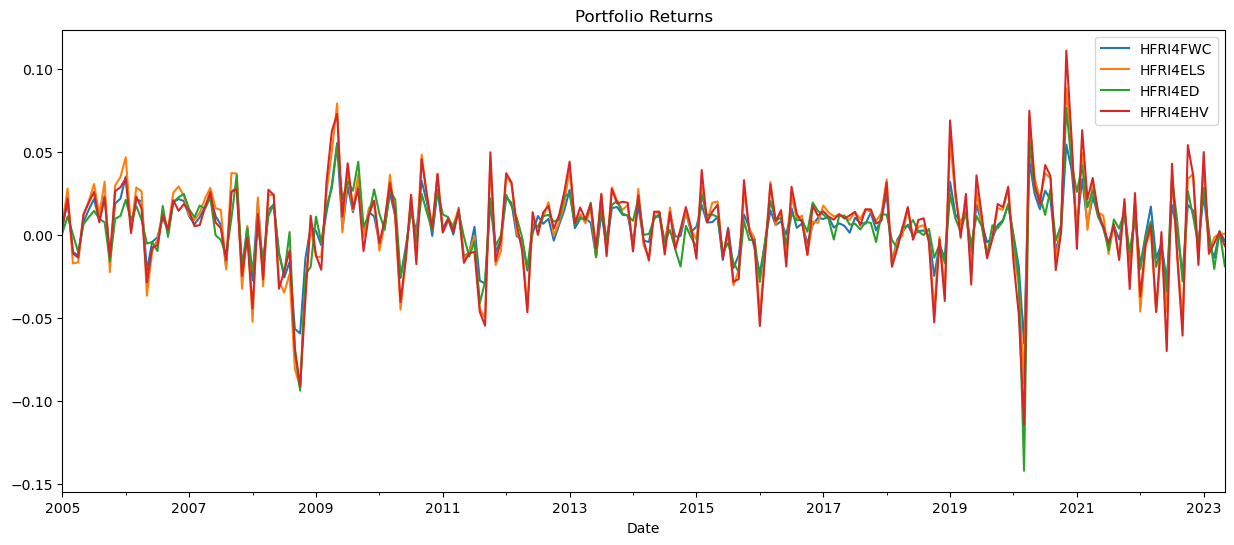

In [11]:
hf_df.plot(figsize=(15, 6)), plt.title('Portfolio Returns')

(<Axes: title={'center': 'Cumulative Portfolio Returns'}, xlabel='Date'>,
 Text(0.5, 1.0, 'Cumulative Portfolio Returns'))

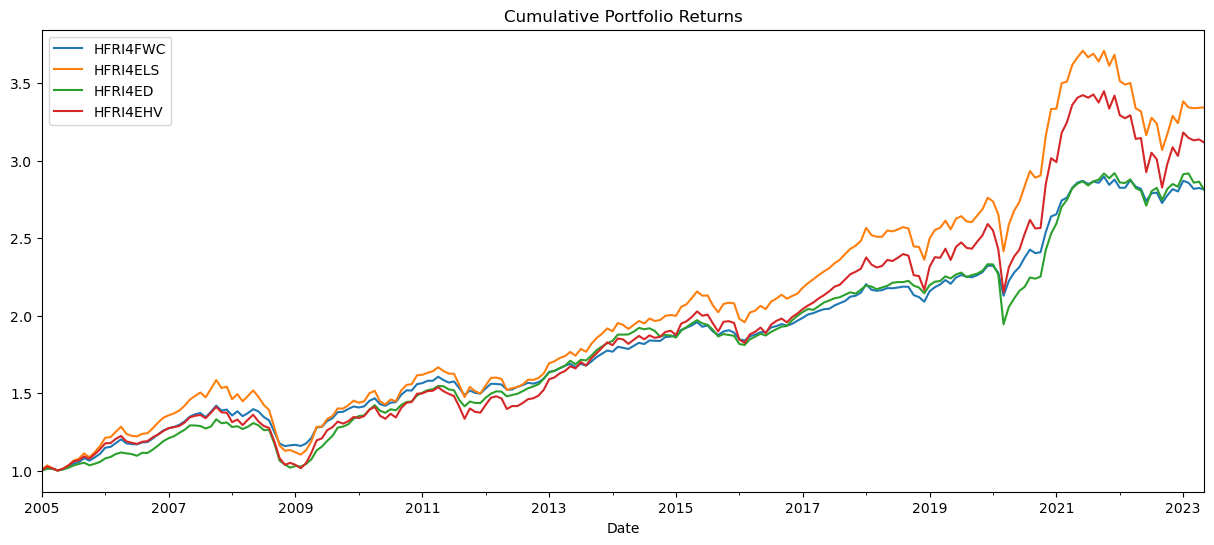

In [12]:
hf_df_cum = (1 + hf_df).cumprod()
hf_df_cum.plot(figsize=(15, 6)), plt.title('Cumulative Portfolio Returns')

In [13]:
asset_perf = pd.DataFrame(dtype=float, columns=['return', 'vol', 'sharpe', 'max drawdown'])
asset_perf['return'] = hf_df_cum.iloc[-1] ** (1/(hf_df_cum.shape[0]/12)) - 1
hf_df_returns = hf_df_cum.pct_change().dropna()
asset_perf['vol'] = hf_df_returns.std() * np.sqrt(12)
asset_perf['sharpe'] = asset_perf['return'] / asset_perf['vol']
asset_perf['max drawdown'] = (1 - hf_df_cum / hf_df_cum.cummax()).max()
asset_perf

,return,vol,sharpe,max drawdown
HFRI4FWC,0.057770,0.058233,0.992042,0.183739
HFRI4ELS,0.067723,0.091006,0.744161,0.303498
HFRI4ED,0.057698,0.071998,0.801382,0.234162
HFRI4EHV,0.063648,0.096866,0.657070,0.280186


# **6. Portfolio Optimization**

In [14]:
# Core MVO Optimization Functions
def mvo_optimize(df, risk_aversion, bounds, expected_returns, covariance_matrix, init_guess):
    if not (0 <= risk_aversion <= 10):
        raise ValueError("Risk aversion must be between 0-10")
    
    # Add input validation
    if len(expected_returns) != covariance_matrix.shape[0]:
        raise ValueError("Dimension mismatch")
    
    def objective(weights):
        portfolio_return = np.dot(weights, expected_returns)
        portfolio_variance = np.dot(weights.T, np.dot(covariance_matrix, weights))
        utility = portfolio_return - (risk_aversion/2) * portfolio_variance
        return -utility  

    constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}

    result = minimize(
        objective,
        init_guess,
        method='SLSQP',
        bounds=bounds,
        constraints=constraints,
        options={'ftol': 1e-9}  # Tighter tolerance
    )

    if not result.success:
        raise ValueError(f"Optimization failed: {result.message}")

    return result.x

In [15]:
def create_bounds(df, min_weight=0.0, max_weight=1.0):

    n_assets = len(df.columns)
    return [(min_weight, max_weight) for _ in range(n_assets)]

def equal_weight_initial_guess(df, target_sum=1.0):

    n_assets = len(df.columns)
    return [target_sum / n_assets] * n_assets

In [16]:
# Quarterly Window Creation
def create_quarter_windows(hf_data, start_date='2012-01-01'):
    """Create quarterly windows starting from Q1 2012"""
    start = pd.to_datetime(start_date)
    end = hf_data.index.max()
    
    quarters = []
    current = start
    
    while current <= end:
        quarter_end = current + pd.DateOffset(months=3) - pd.DateOffset(days=1)
        if quarter_end <= end:
            # 7-year (84 months) lookback window
            train_start = quarter_end - pd.DateOffset(months=84)
            quarters.append({
                'quarter_label': f"Q{quarter_end.quarter} {quarter_end.year}",
                'quarter_date': quarter_end,
                'train_start': train_start,
                'train_end': quarter_end
            })
        current = current + pd.DateOffset(months=3)
    
    return quarters

In [17]:
def get_quarter_training_data(hf_data, train_start, train_end):
    """Extract training data for the specific window"""
    return hf_data[(hf_data.index >= train_start) & (hf_data.index <= train_end)]


In [18]:
# Main Quarterly MVO Function
def quarterly_mvo_optimization(hf_data, alpha=2.0, start_date='2012-01-01'):
    """
    Quarterly MVO using historical means + sample covariance (your original approach)
    
    Parameters:
    - hf_data: DataFrame with hedge fund monthly returns
    - alpha: Risk aversion parameter
    - start_date: Start date for optimization (default Q1 2012)
    
    Returns:
    - DataFrame with quarterly optimal weights in percentage format
    """
    quarters = create_quarter_windows(hf_data, start_date)
    print(f"Processing {len(quarters)} quarters starting from {start_date}...")
    
    results = []
    
    for i, quarter_info in enumerate(quarters):
        print(f"Processing {quarter_info['quarter_label']} ({i+1}/{len(quarters)})")
        
        try:
            # Get 7-year training data for this quarter
            df_train = get_quarter_training_data(
                hf_data, 
                quarter_info['train_start'], 
                quarter_info['train_end']
            )
            
            if len(df_train) < 60:  # Need minimum 5 years of data
                print(f"  Skipping - insufficient data ({len(df_train)} months)")
                continue
            
            # Calculate inputs using your original approach
            expected_returns = df_train.mean().values * 12  # Annualized historical means
            covariance_matrix = df_train.cov().values * 12  # Annualized sample covariance
            names = df_train.columns.tolist()
            bounds = create_bounds(df_train)
            init_guess = equal_weight_initial_guess(df_train)
            
            # Optimize using your original MVO function
            optimal_weights_raw = mvo_optimize(
                df_train, 
                risk_aversion=alpha, 
                bounds=bounds,
                expected_returns=expected_returns,
                covariance_matrix=covariance_matrix,
                init_guess=init_guess
            )
            
            # Normalize weights to sum to 1
            total_weight = sum(optimal_weights_raw)
            normalized_weights = optimal_weights_raw / total_weight
            
            # Convert to percentages
            weights_as_percent = [f"{w * 100:.2f}%" for w in normalized_weights]
            
            # Store results
            result_row = {'Quarter': quarter_info['quarter_label']}
            for name, weight_pct in zip(names, weights_as_percent):
                result_row[name] = weight_pct
            
            results.append(result_row)
            
            # Print weights for this quarter
            print(f"  Optimal weights for {quarter_info['quarter_label']}:")
            for name, weight in zip(names, weights_as_percent):
                print(f"    {name}: {weight}")
            
        except Exception as e:
            print(f"  Error in {quarter_info['quarter_label']}: {e}")
            continue
    
    print(f"\nCompleted optimization for {len(results)} quarters")
    return pd.DataFrame(results)

In [19]:
portfolio_weights_λ_0_05 = quarterly_mvo_optimization(hf_df, alpha=0.05)

Processing 45 quarters starting from 2012-01-01...
Processing Q1 2012 (1/45)
  Optimal weights for Q1 2012:
    HFRI4FWC: 0.00%
    HFRI4ELS: 100.00%
    HFRI4ED: 0.00%
    HFRI4EHV: 0.00%
Processing Q2 2012 (2/45)
  Optimal weights for Q2 2012:
    HFRI4FWC: 0.00%
    HFRI4ELS: 100.00%
    HFRI4ED: 0.00%
    HFRI4EHV: 0.00%
Processing Q3 2012 (3/45)
  Optimal weights for Q3 2012:
    HFRI4FWC: 0.00%
    HFRI4ELS: 100.00%
    HFRI4ED: 0.00%
    HFRI4EHV: 0.00%
Processing Q4 2012 (4/45)
  Optimal weights for Q4 2012:
    HFRI4FWC: 0.00%
    HFRI4ELS: 0.00%
    HFRI4ED: 100.00%
    HFRI4EHV: 0.00%
Processing Q1 2013 (5/45)
  Optimal weights for Q1 2013:
    HFRI4FWC: 0.00%
    HFRI4ELS: 0.00%
    HFRI4ED: 100.00%
    HFRI4EHV: 0.00%
Processing Q2 2013 (6/45)
  Optimal weights for Q2 2013:
    HFRI4FWC: 0.00%
    HFRI4ELS: 0.00%
    HFRI4ED: 100.00%
    HFRI4EHV: 0.00%
Processing Q3 2013 (7/45)
  Optimal weights for Q3 2013:
    HFRI4FWC: 0.00%
    HFRI4ELS: 0.00%
    HFRI4ED: 100.00%
   

In [20]:
portfolio_weights_λ_10 = quarterly_mvo_optimization(hf_df, alpha=10)

Processing 45 quarters starting from 2012-01-01...
Processing Q1 2012 (1/45)
  Optimal weights for Q1 2012:
    HFRI4FWC: 100.00%
    HFRI4ELS: 0.00%
    HFRI4ED: 0.00%
    HFRI4EHV: 0.00%
Processing Q2 2012 (2/45)
  Optimal weights for Q2 2012:
    HFRI4FWC: 100.00%
    HFRI4ELS: 0.00%
    HFRI4ED: 0.00%
    HFRI4EHV: 0.00%
Processing Q3 2012 (3/45)
  Optimal weights for Q3 2012:
    HFRI4FWC: 100.00%
    HFRI4ELS: 0.00%
    HFRI4ED: 0.00%
    HFRI4EHV: 0.00%
Processing Q4 2012 (4/45)
  Optimal weights for Q4 2012:
    HFRI4FWC: 35.22%
    HFRI4ELS: 0.00%
    HFRI4ED: 64.78%
    HFRI4EHV: 0.00%
Processing Q1 2013 (5/45)
  Optimal weights for Q1 2013:
    HFRI4FWC: 22.24%
    HFRI4ELS: 0.00%
    HFRI4ED: 77.76%
    HFRI4EHV: 0.00%
Processing Q2 2013 (6/45)
  Optimal weights for Q2 2013:
    HFRI4FWC: 15.46%
    HFRI4ELS: 0.00%
    HFRI4ED: 84.54%
    HFRI4EHV: 0.00%
Processing Q3 2013 (7/45)
  Optimal weights for Q3 2013:
    HFRI4FWC: 0.00%
    HFRI4ELS: 0.00%
    HFRI4ED: 100.00%
   

In [21]:
portfolio_weights_λ_0_05.head()

,Quarter,HFRI4FWC,HFRI4ELS,HFRI4ED,HFRI4EHV
0,Q1 2012,0.00%,100.00%,0.00%,0.00%
1,Q2 2012,0.00%,100.00%,0.00%,0.00%
2,Q3 2012,0.00%,100.00%,0.00%,0.00%
3,Q4 2012,0.00%,0.00%,100.00%,0.00%
4,Q1 2013,0.00%,0.00%,100.00%,0.00%


In [22]:
portfolio_weights_λ_10.head()

,Quarter,HFRI4FWC,HFRI4ELS,HFRI4ED,HFRI4EHV
0,Q1 2012,100.00%,0.00%,0.00%,0.00%
1,Q2 2012,100.00%,0.00%,0.00%,0.00%
2,Q3 2012,100.00%,0.00%,0.00%,0.00%
3,Q4 2012,35.22%,0.00%,64.78%,0.00%
4,Q1 2013,22.24%,0.00%,77.76%,0.00%


In [23]:
output_folder = '/Users/jatindhurve/Desktop/PROJECTS/main_HF_project/all_output_results'

In [24]:
portfolio_weights_λ_0_05.to_excel(os.path.join(output_folder, 'mvo_weights_λ=0.05.xlsx'), index=False)

In [25]:
portfolio_weights_λ_10.to_excel(os.path.join(output_folder, 'mvo_weights_λ=10.xlsx'), index=False)


# **7. Pie Charts of Portfolio Weights**

In [33]:
# Read the Excel files
portfolio_weights_05 = pd.read_excel('all_output_results/mvo_weights_λ=0.05.xlsx')
portfolio_weights_10 = pd.read_excel('all_output_results/mvo_weights_λ=10.xlsx')

/var/folders/ky/n1n3tvzn3zb6_44x8nfzwn700000gn/T/ipykernel_75260/3246851396.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Blues')


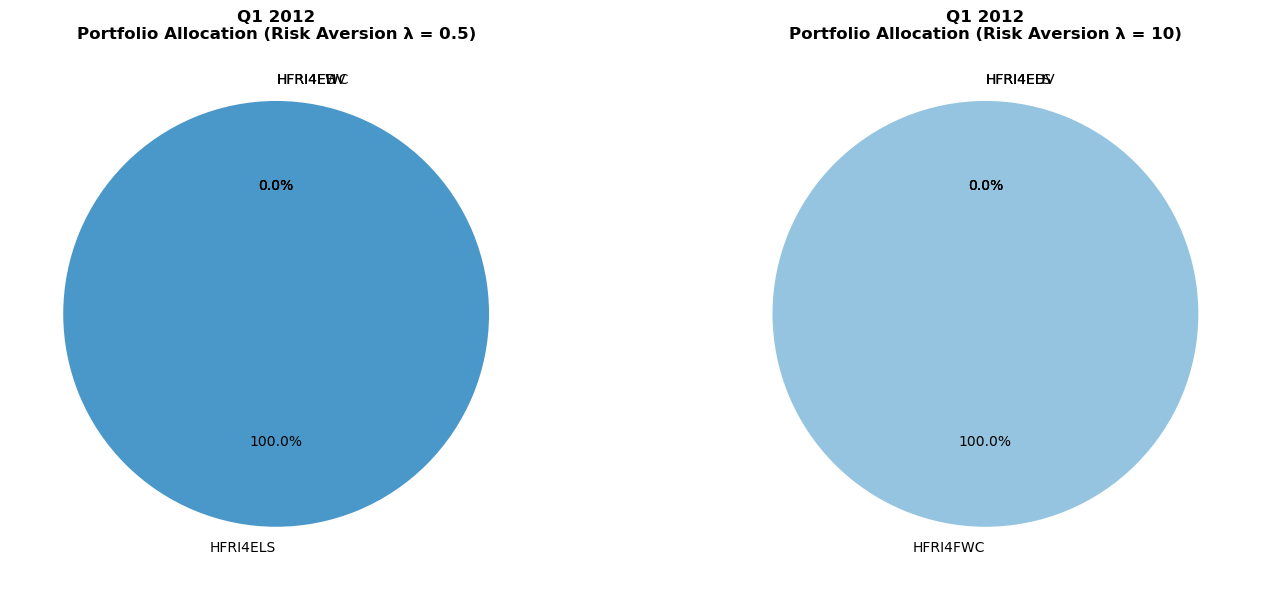

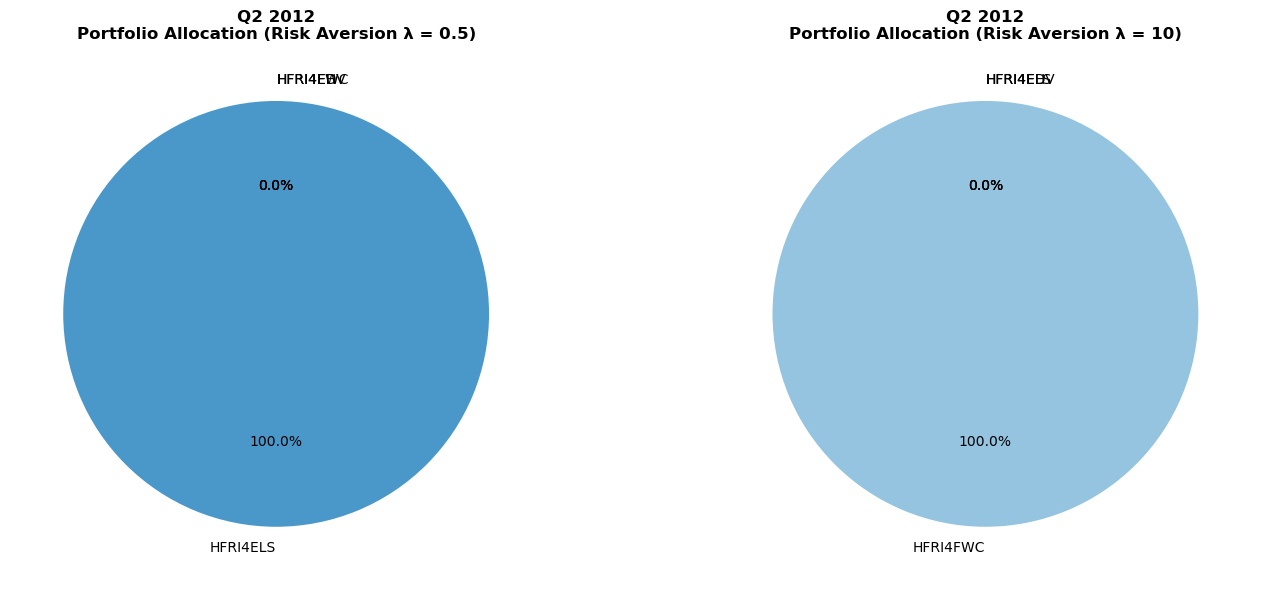

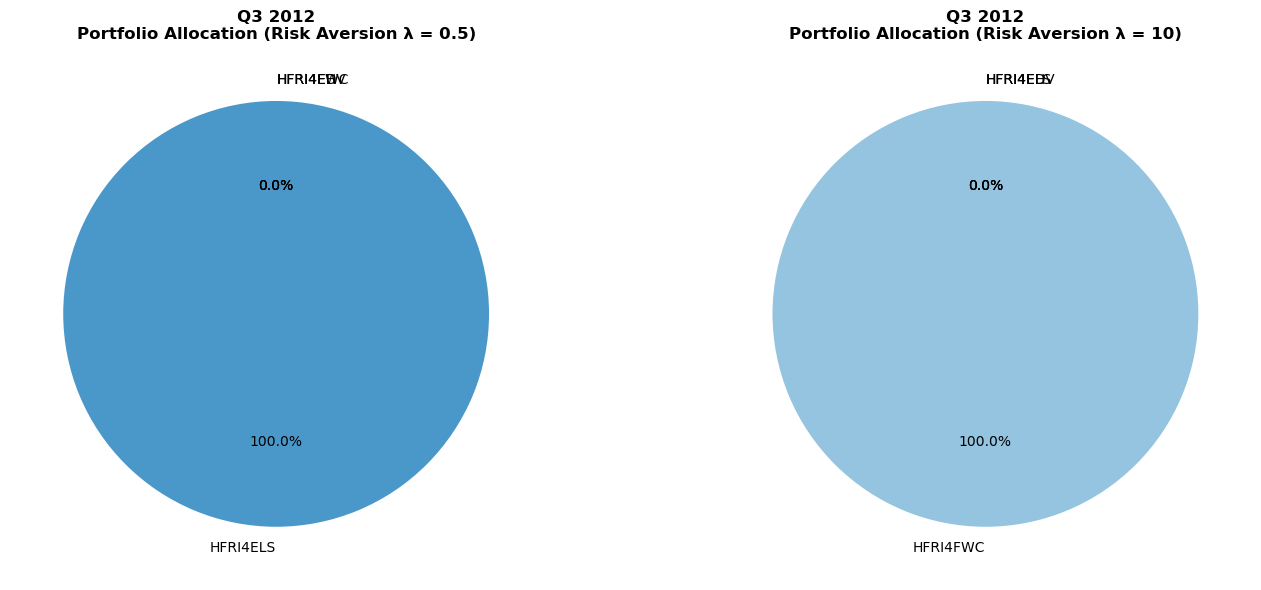

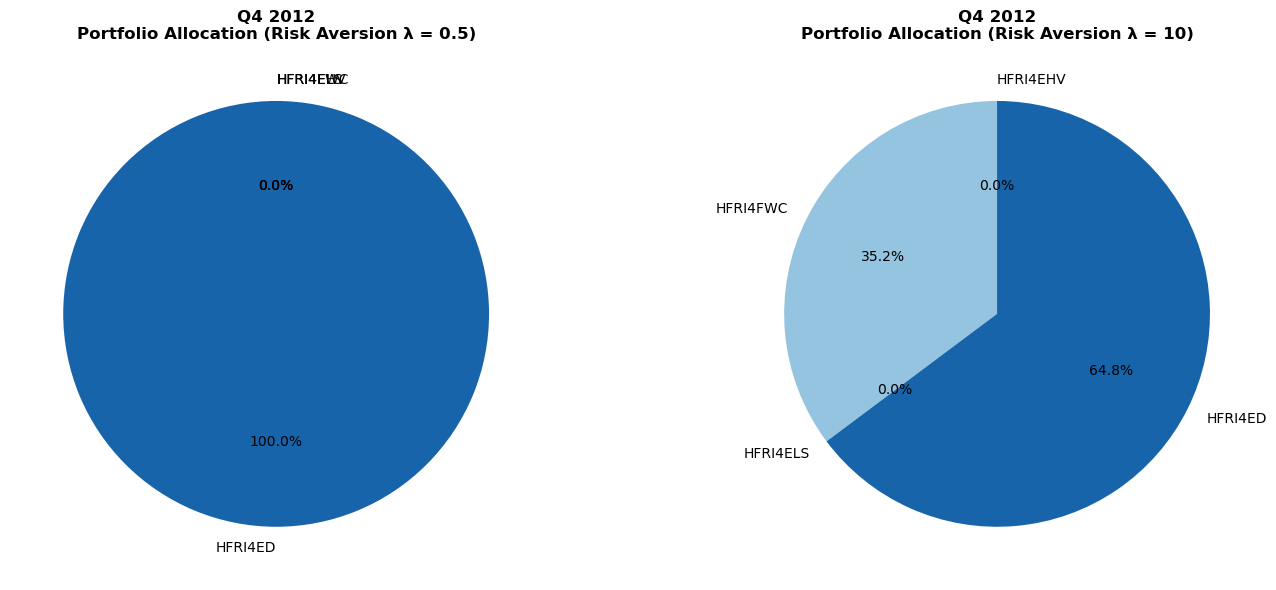

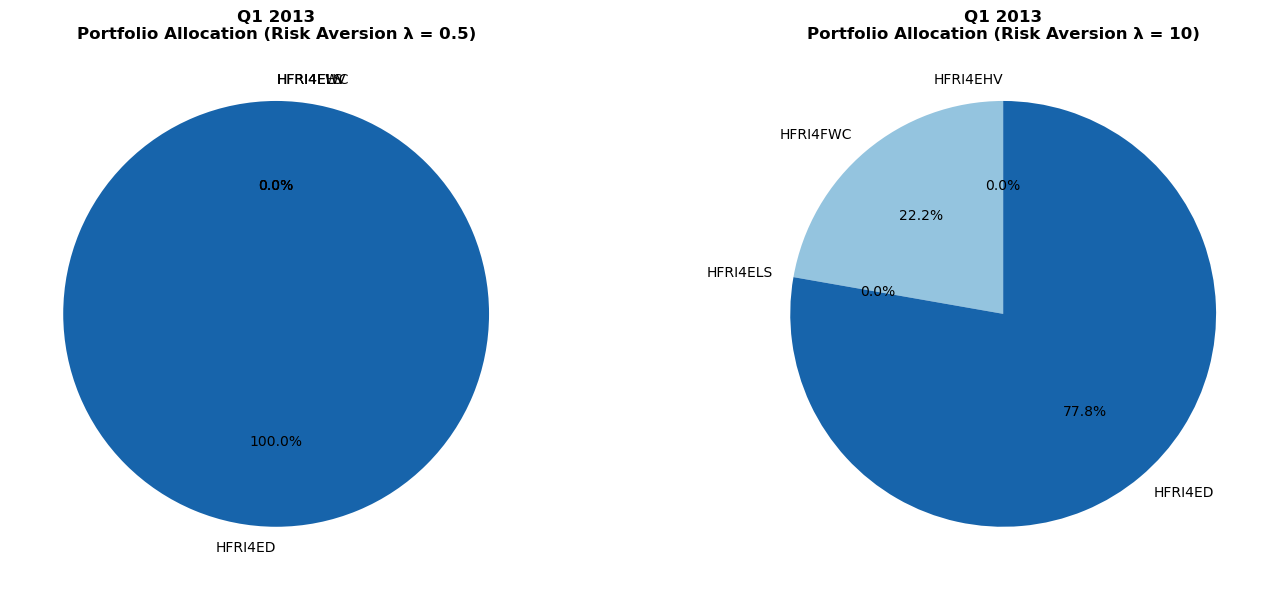

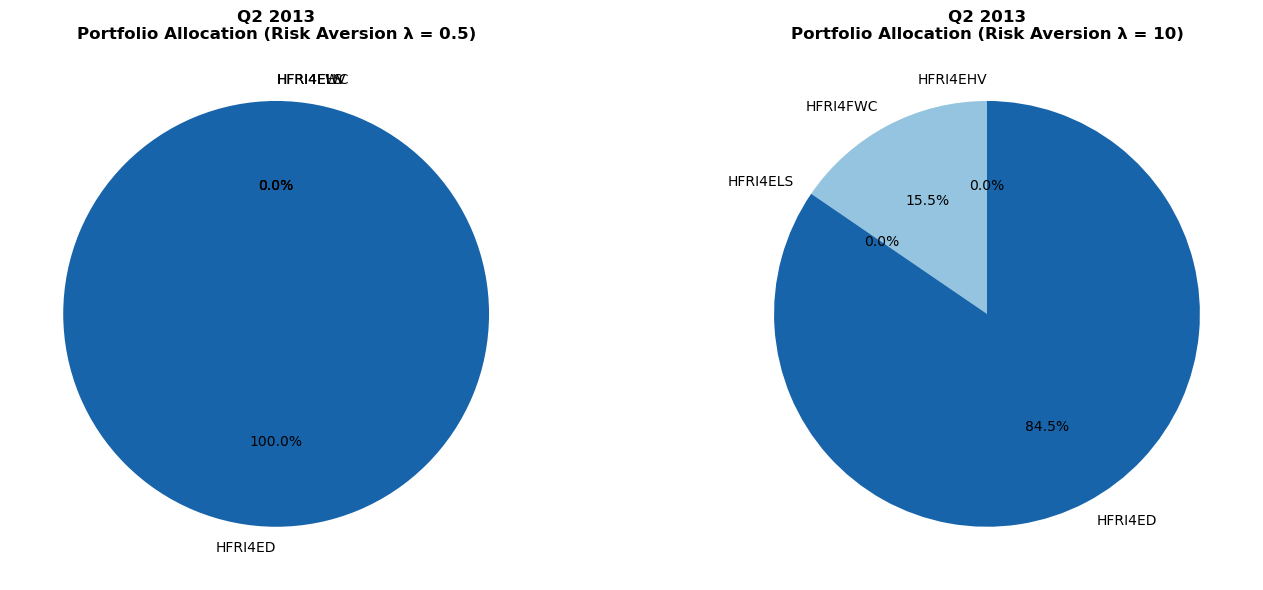

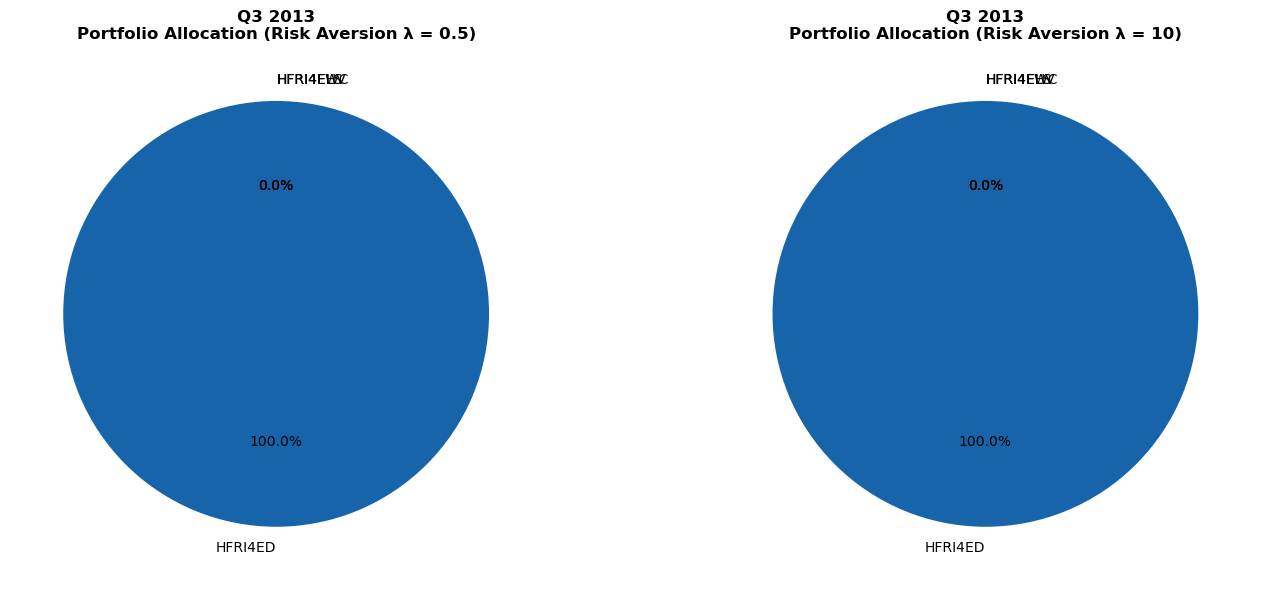

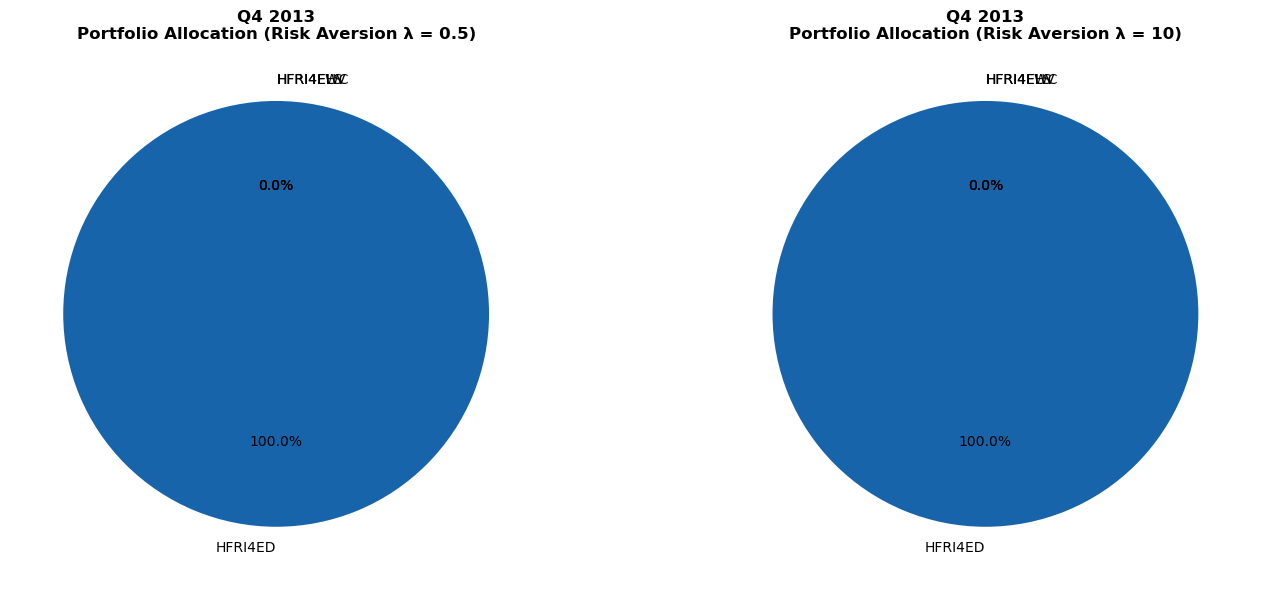

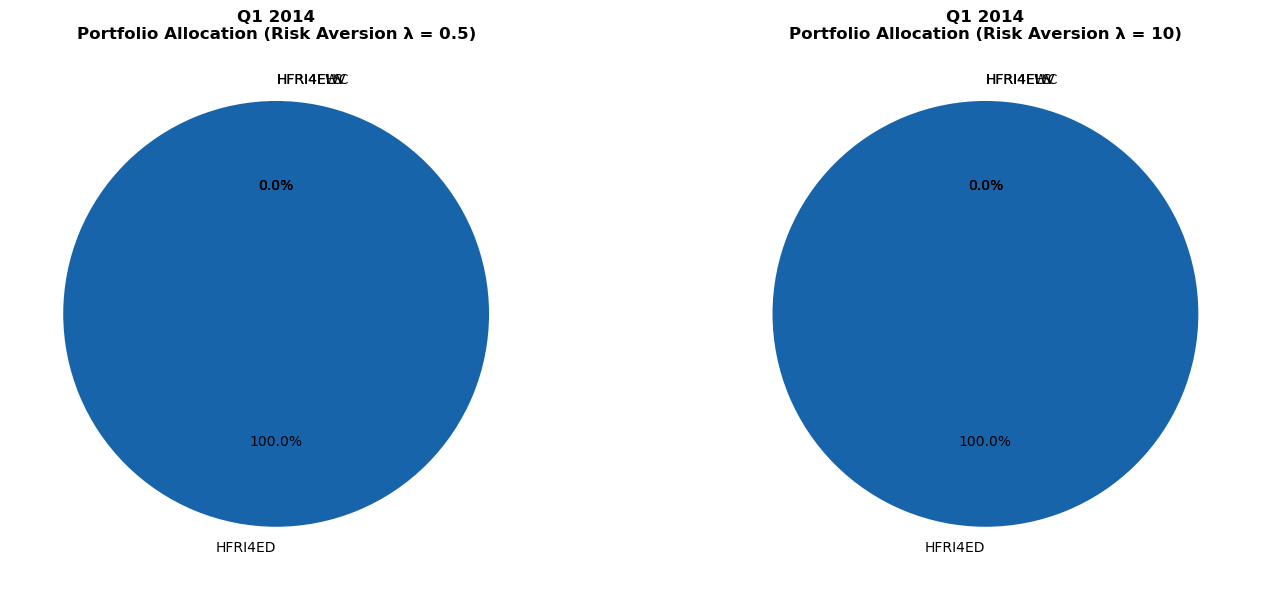

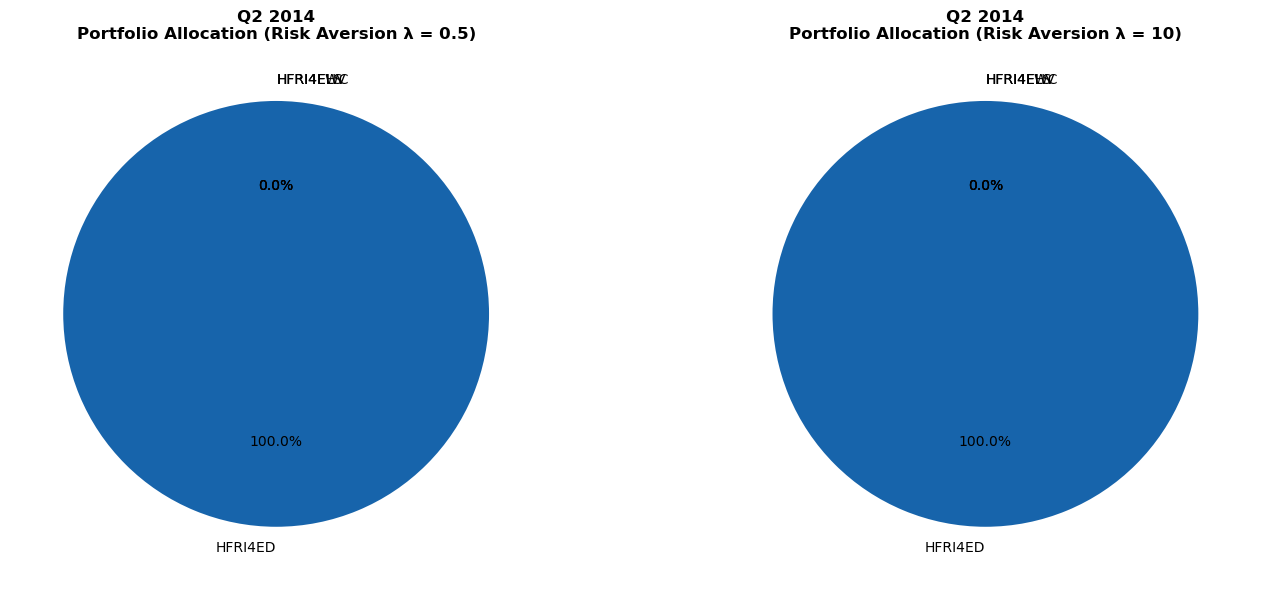

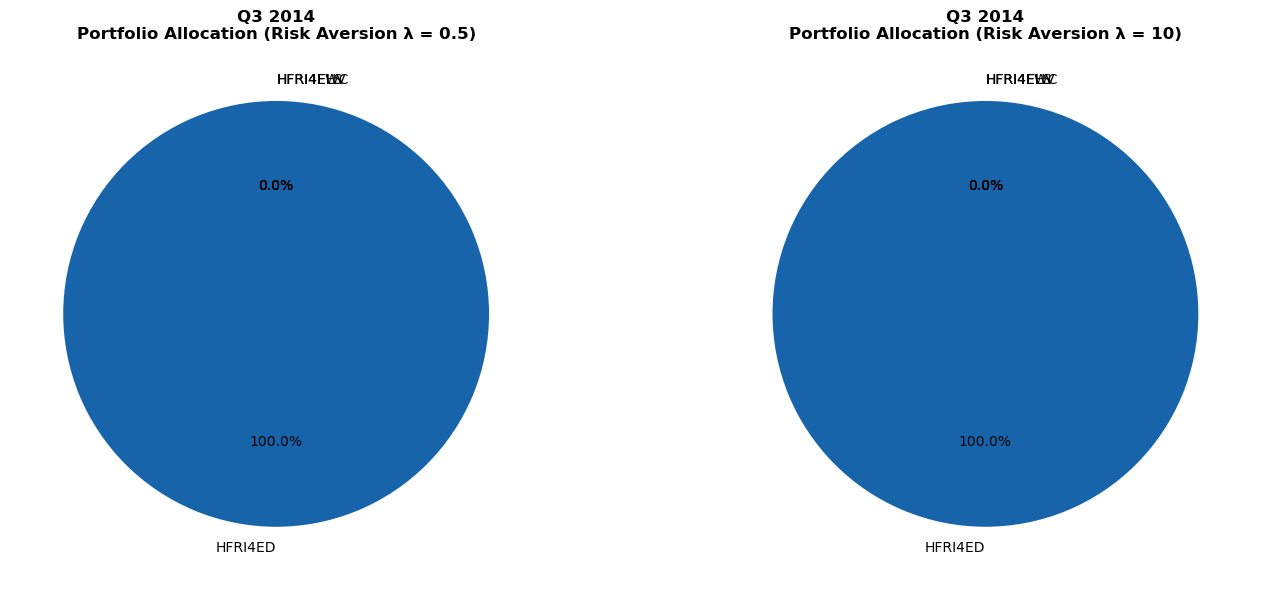

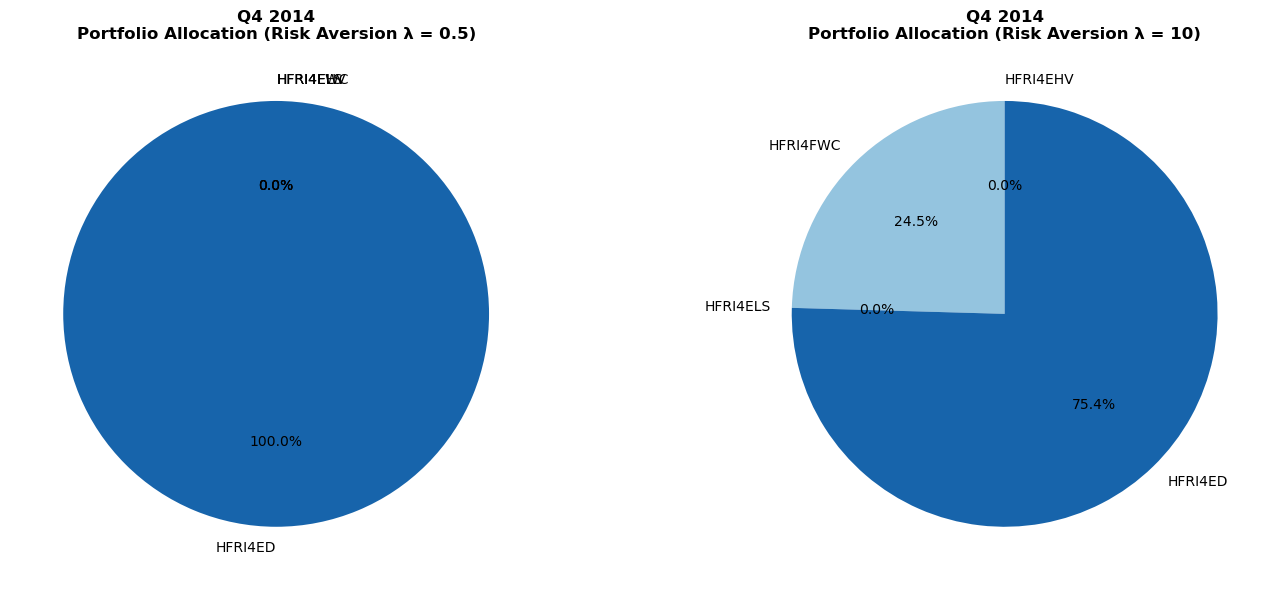

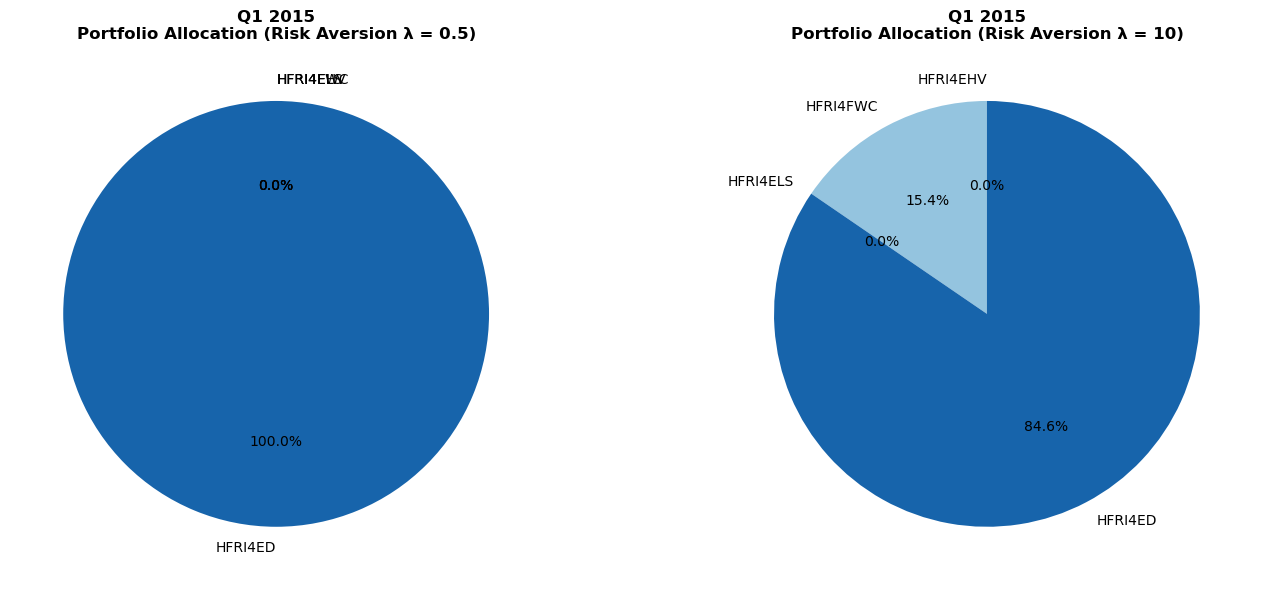

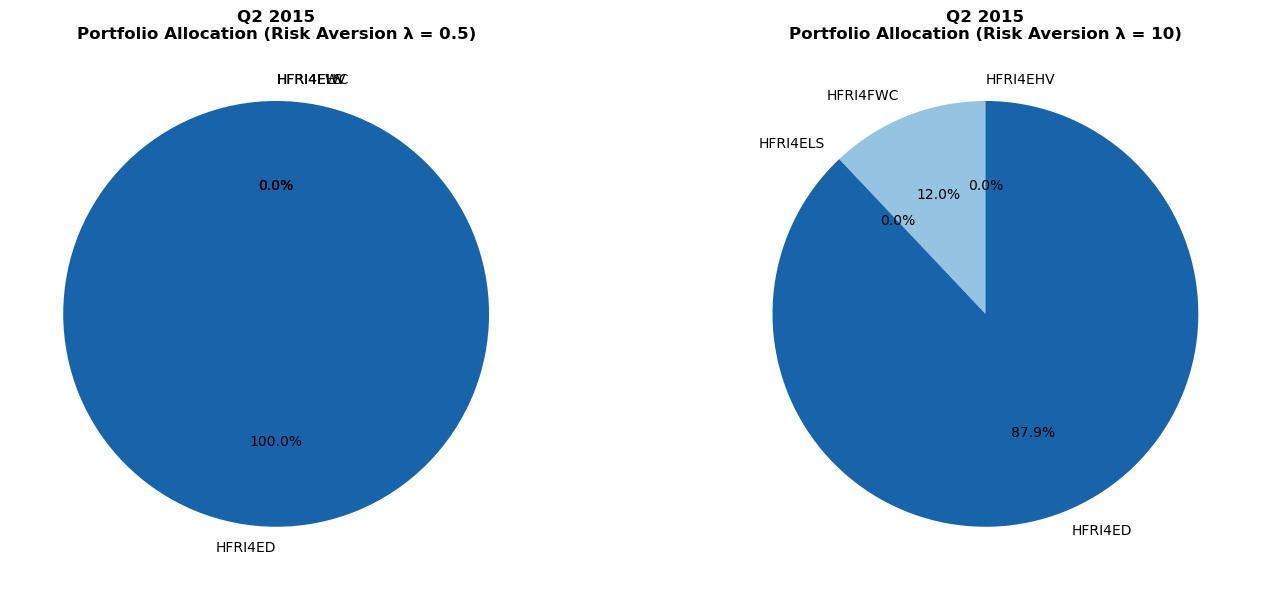

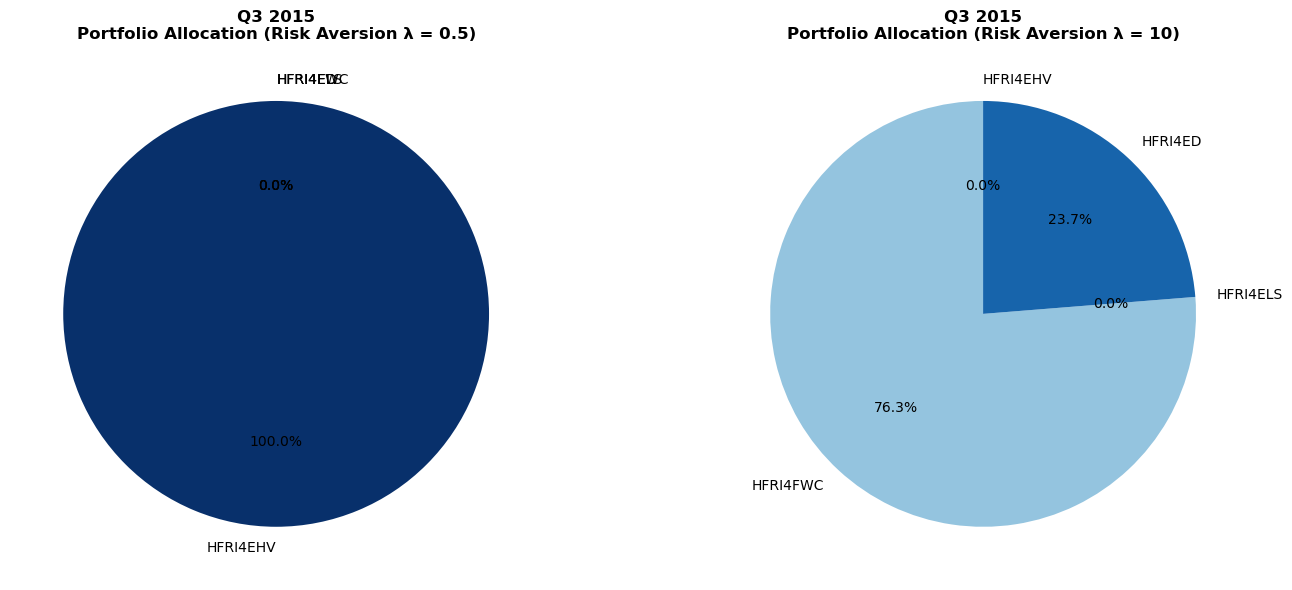

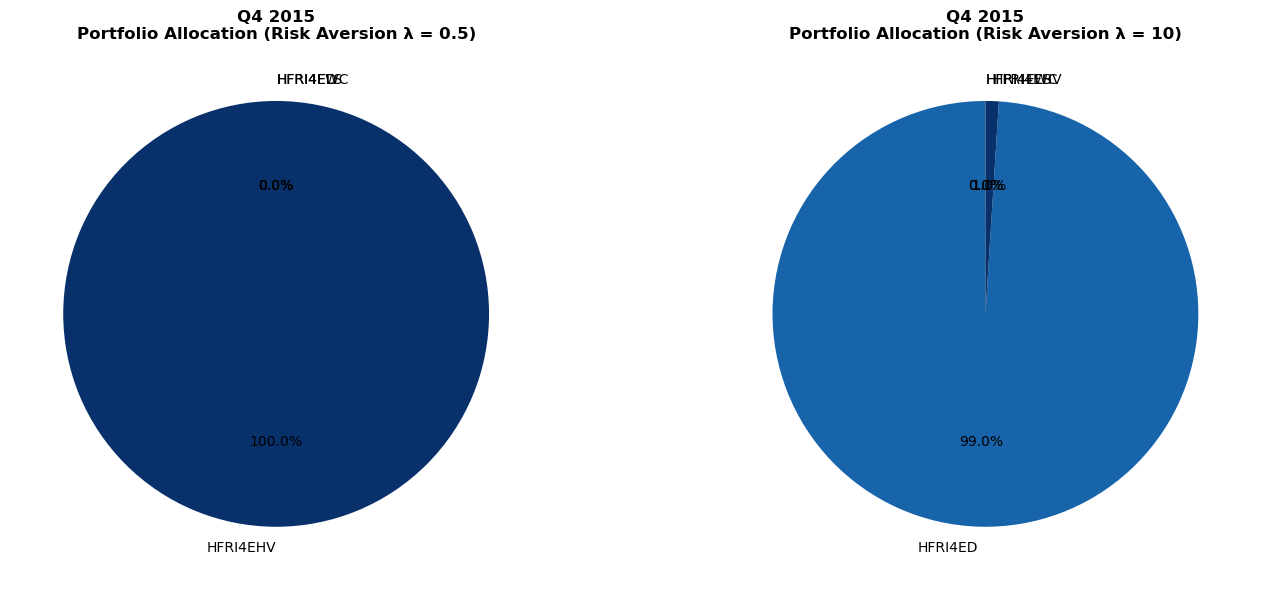

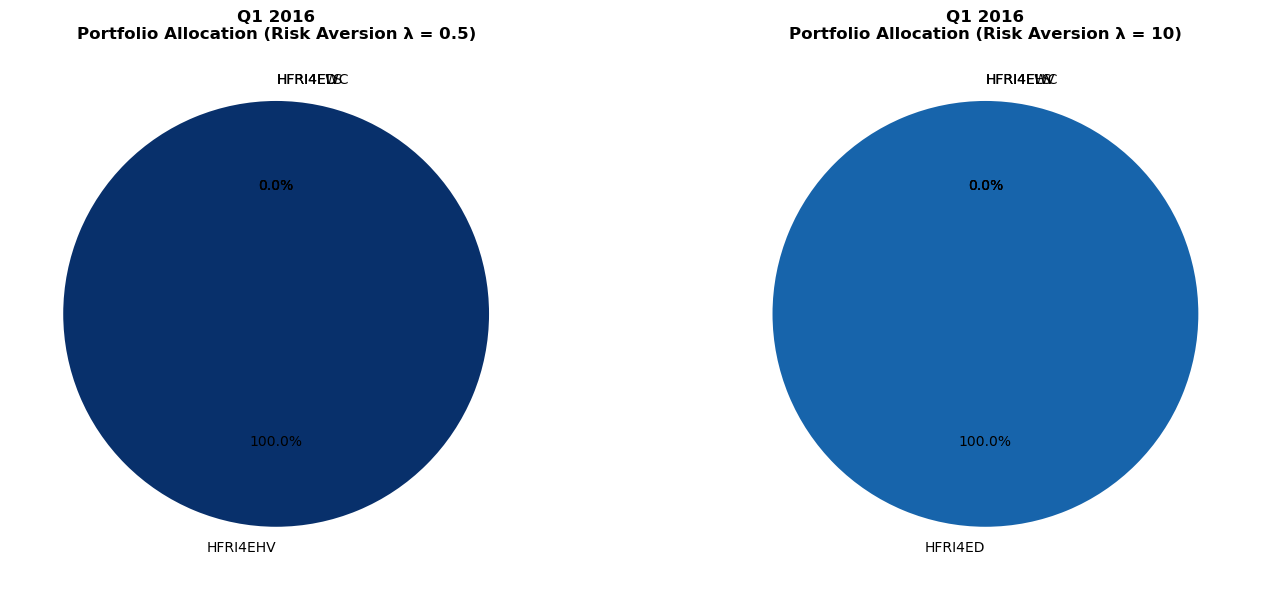

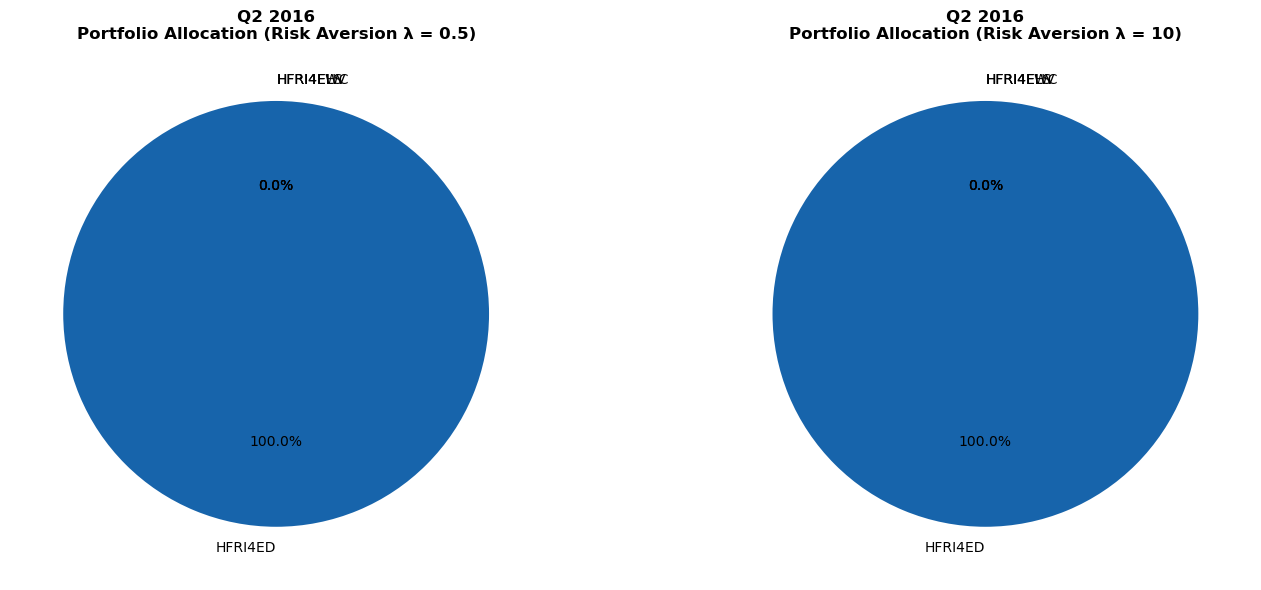

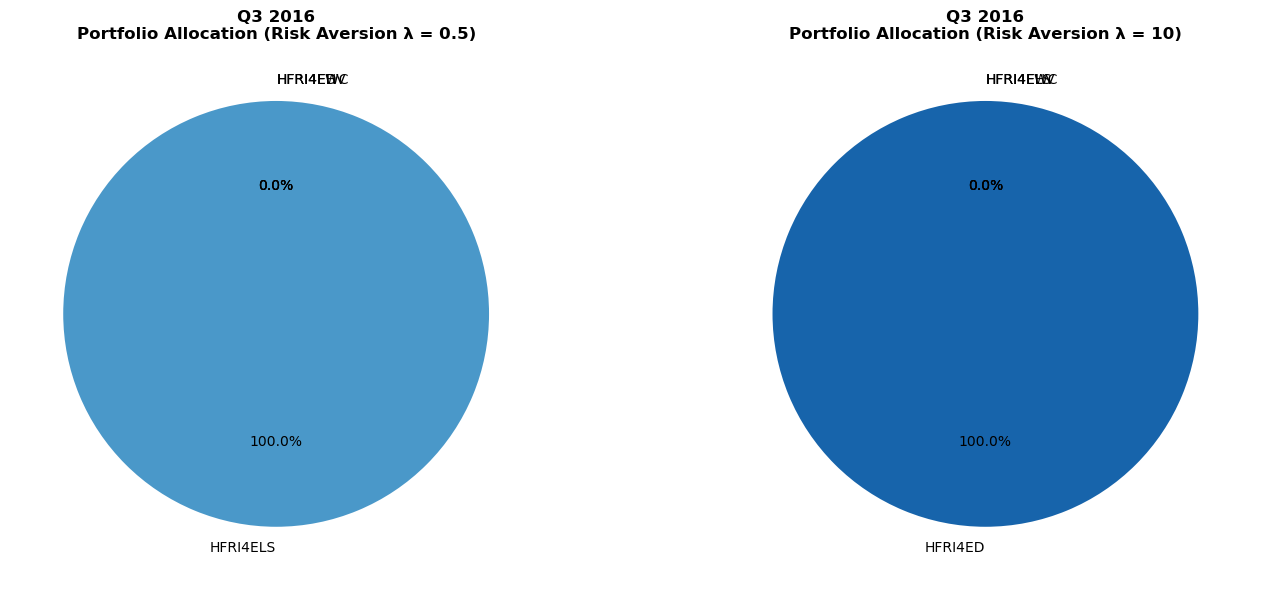

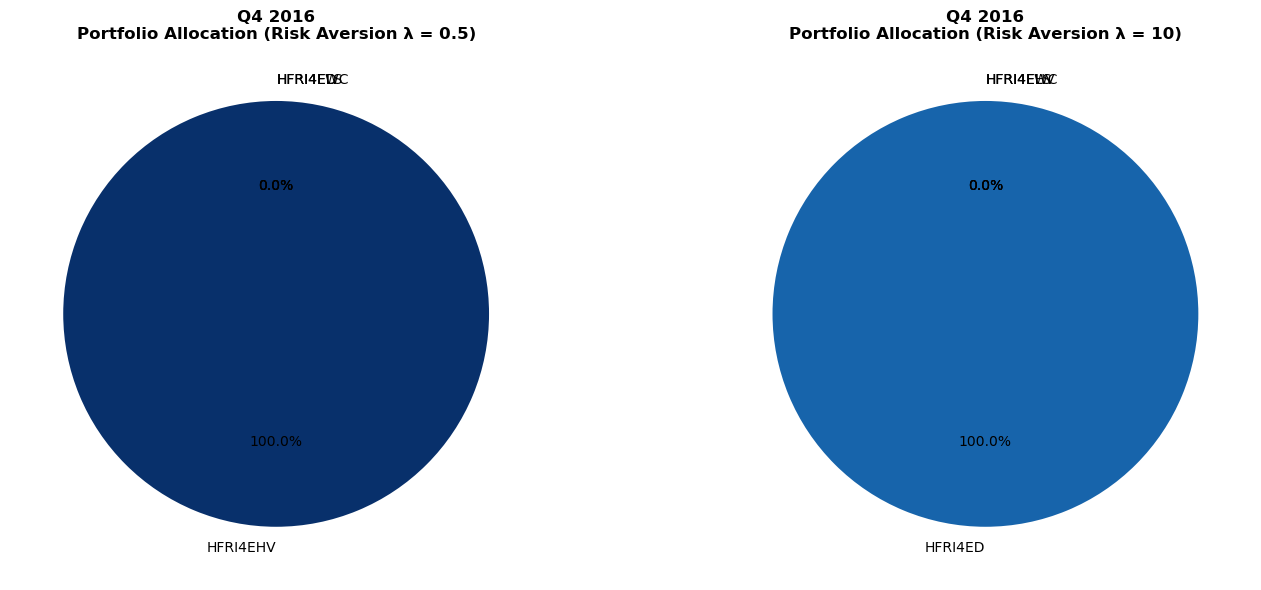

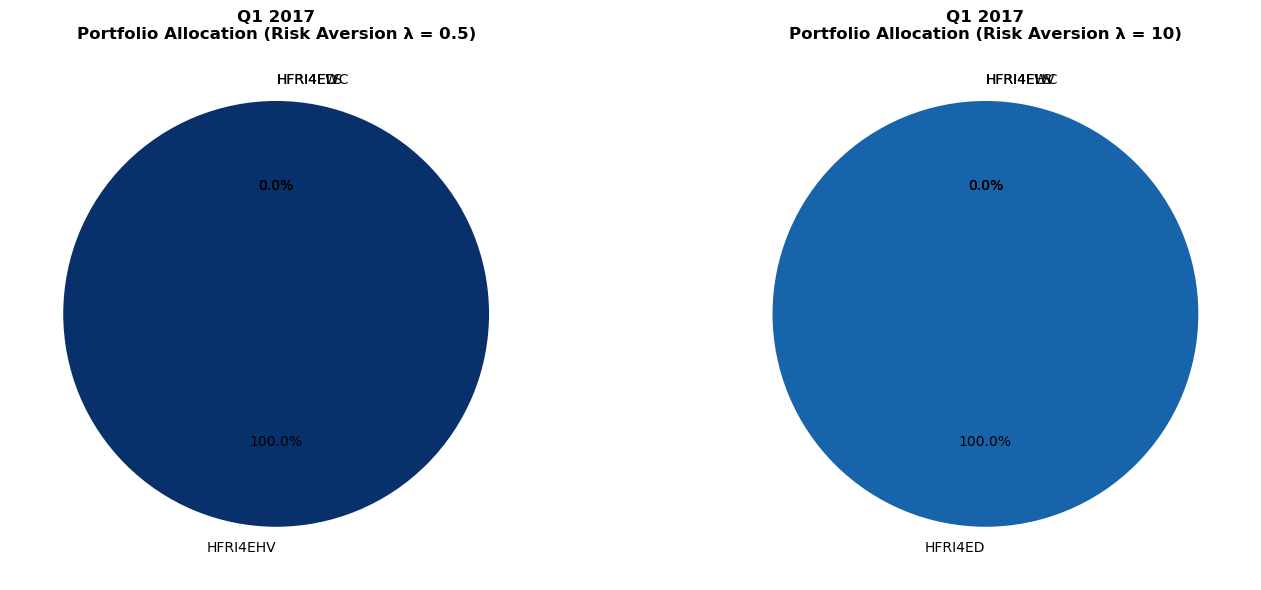

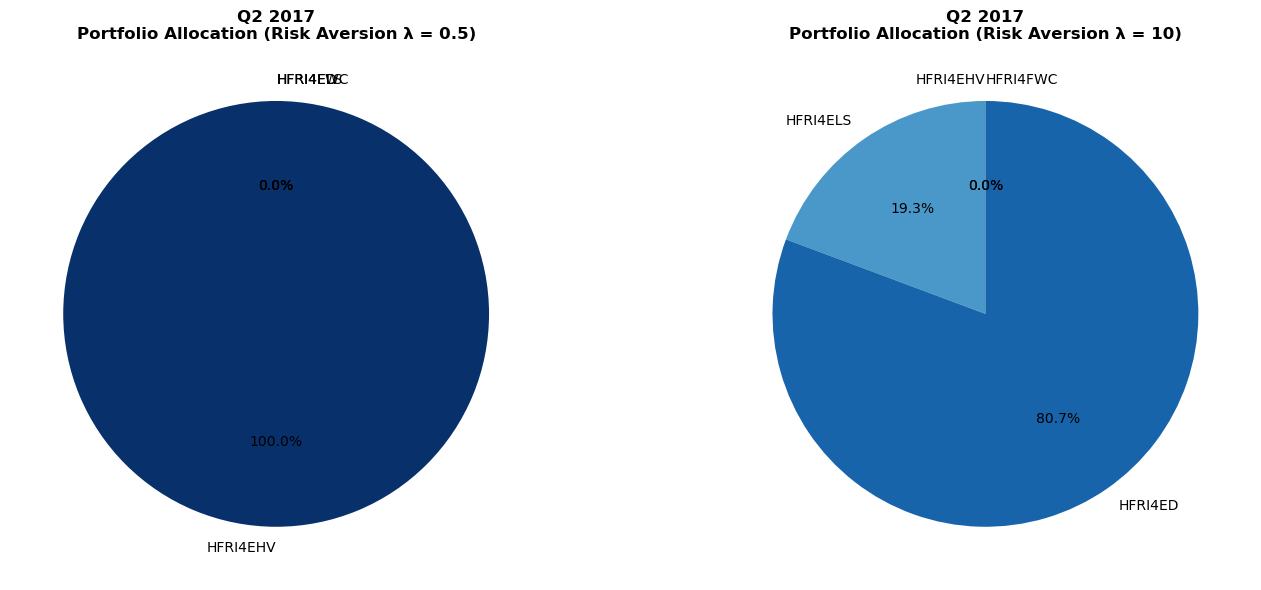

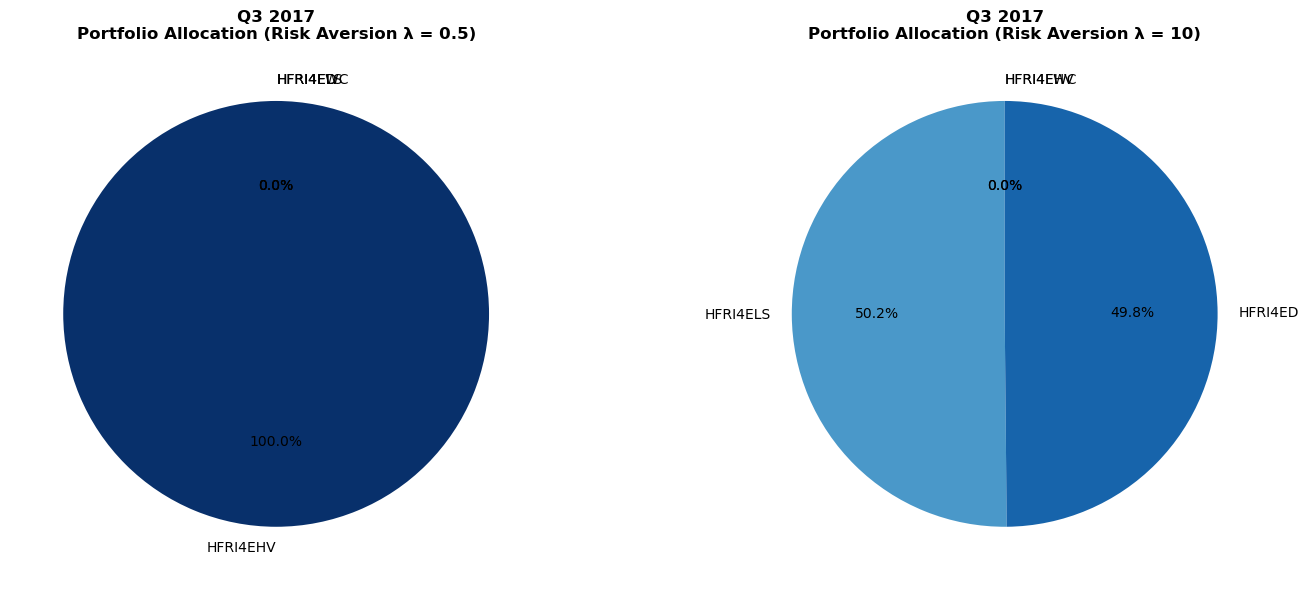

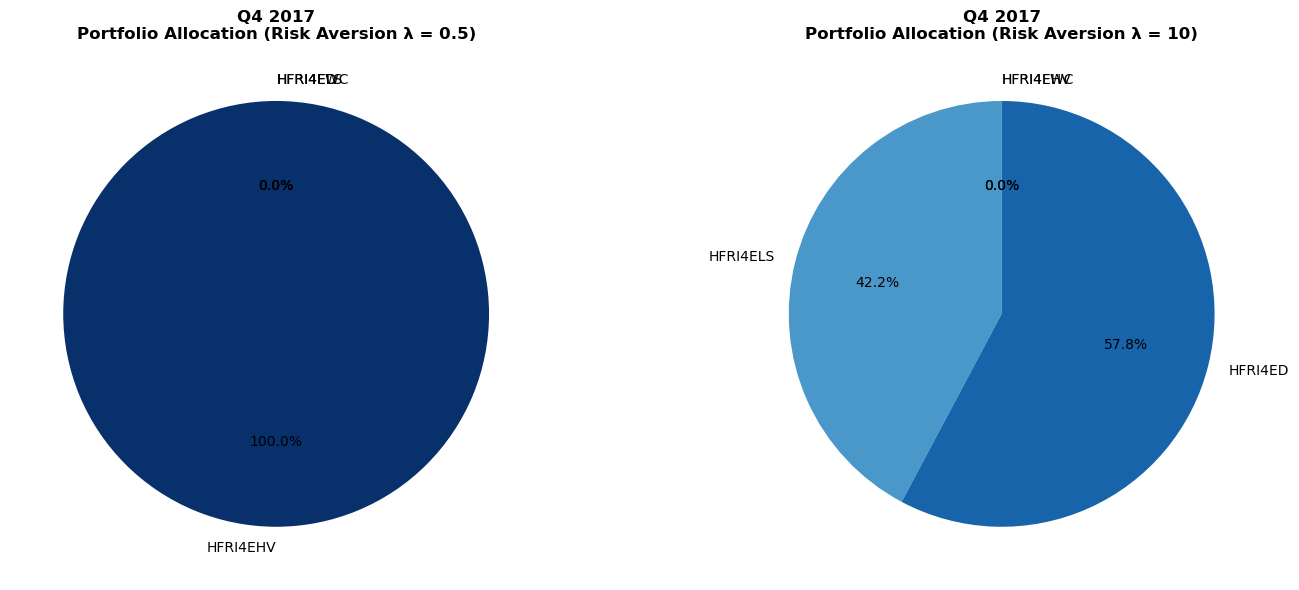

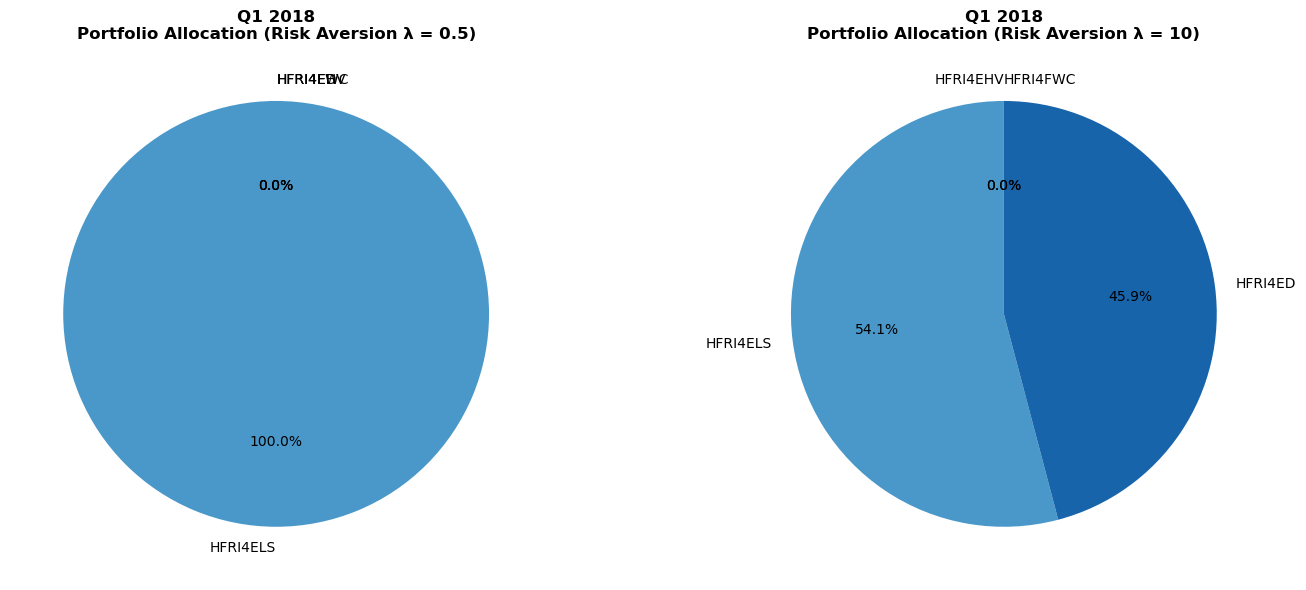

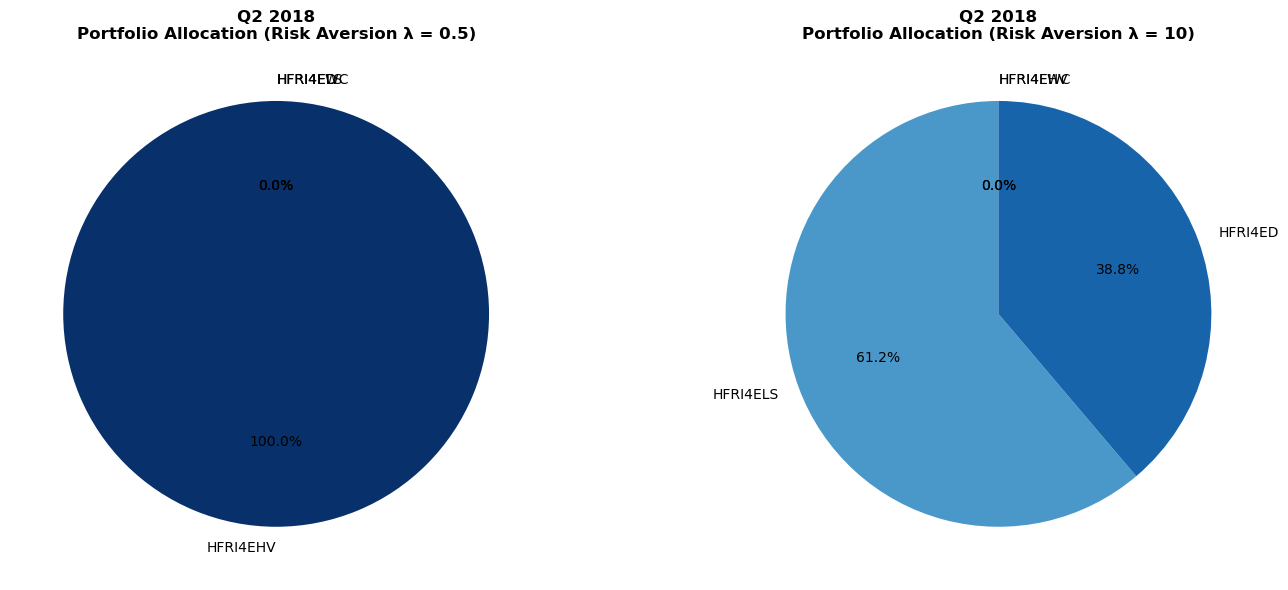

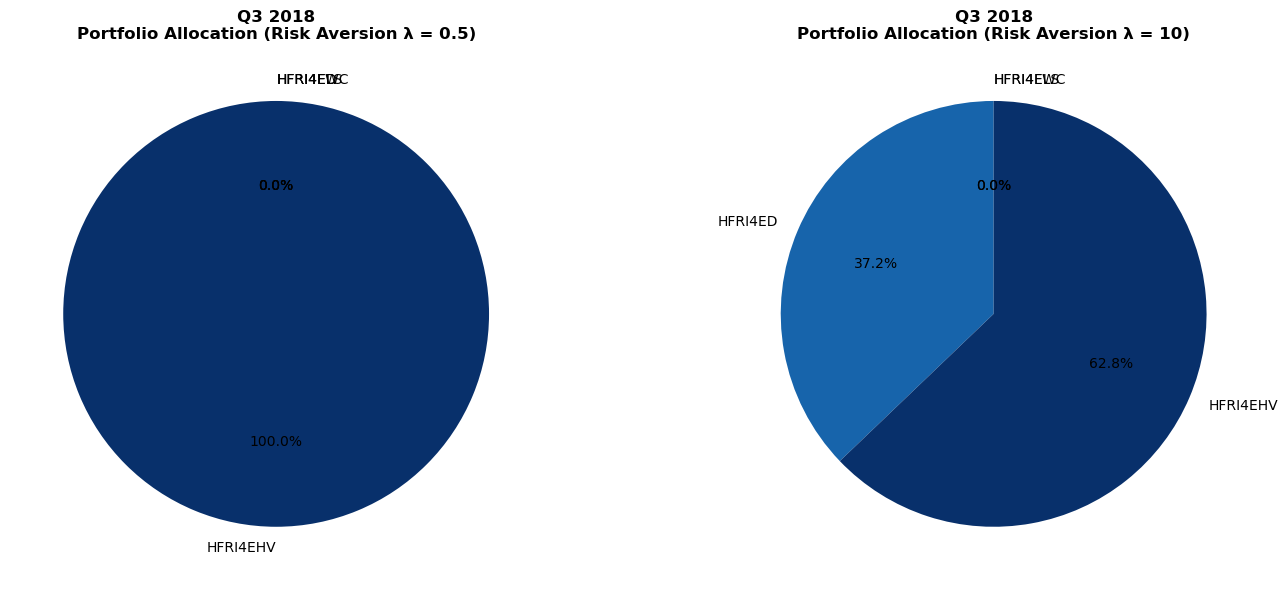

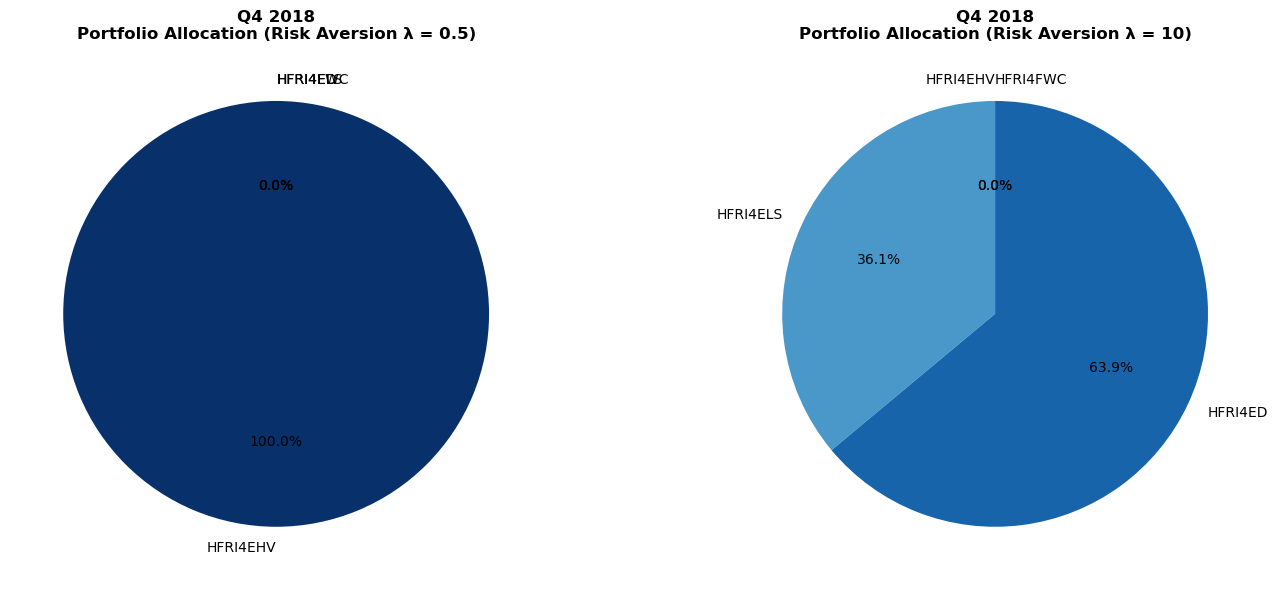

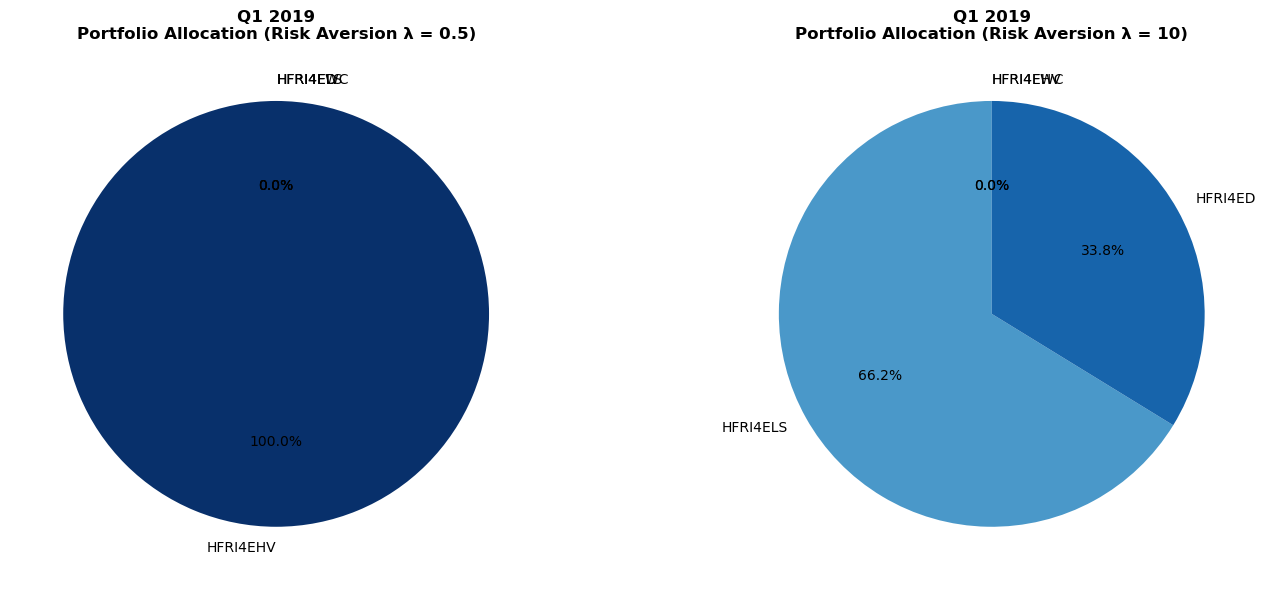

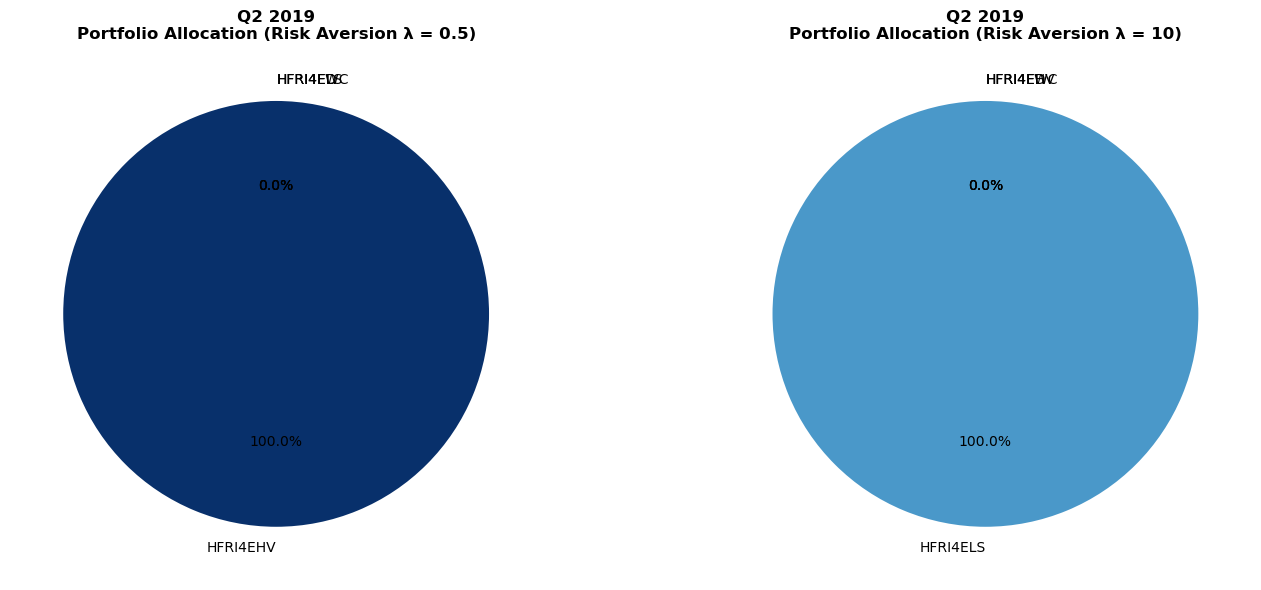

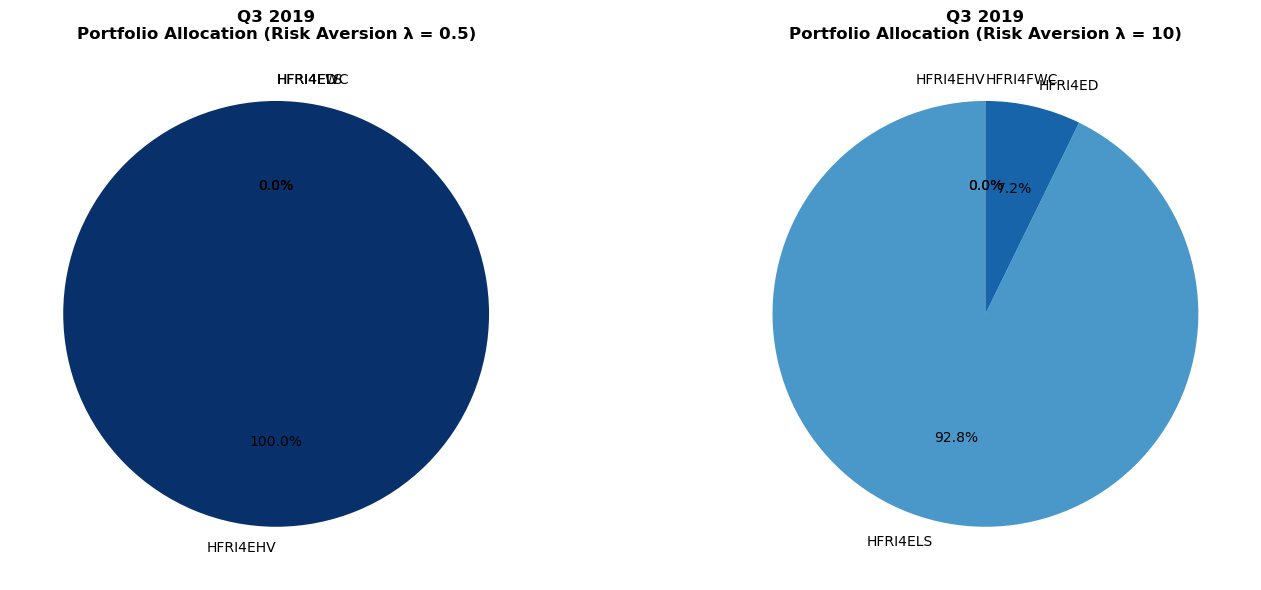

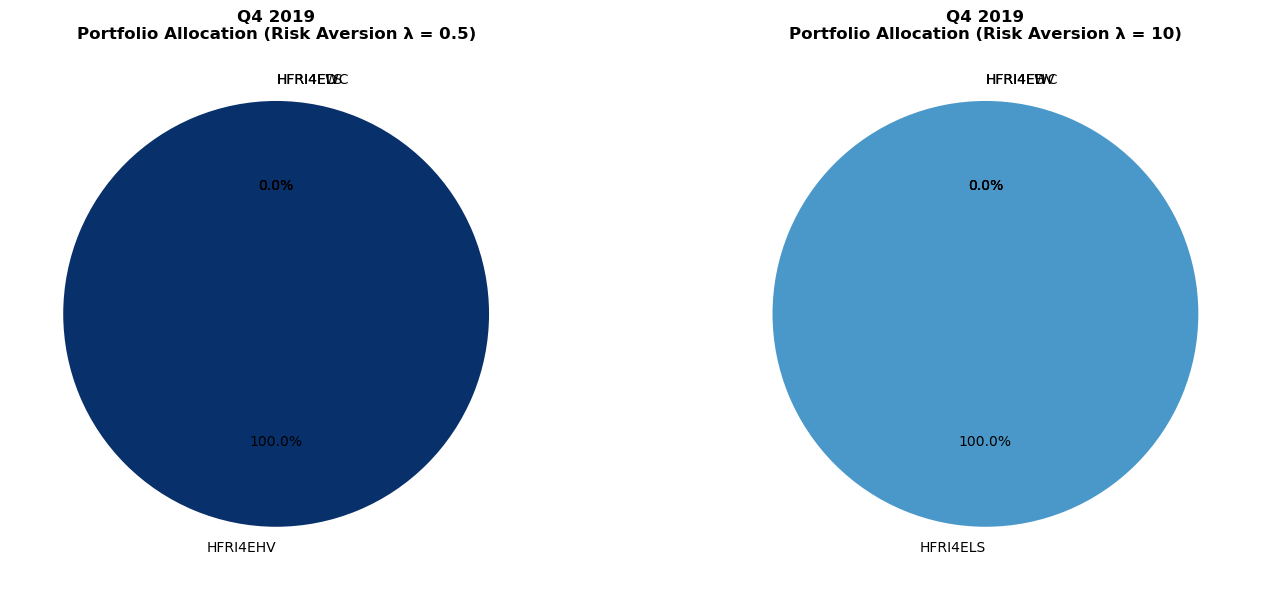

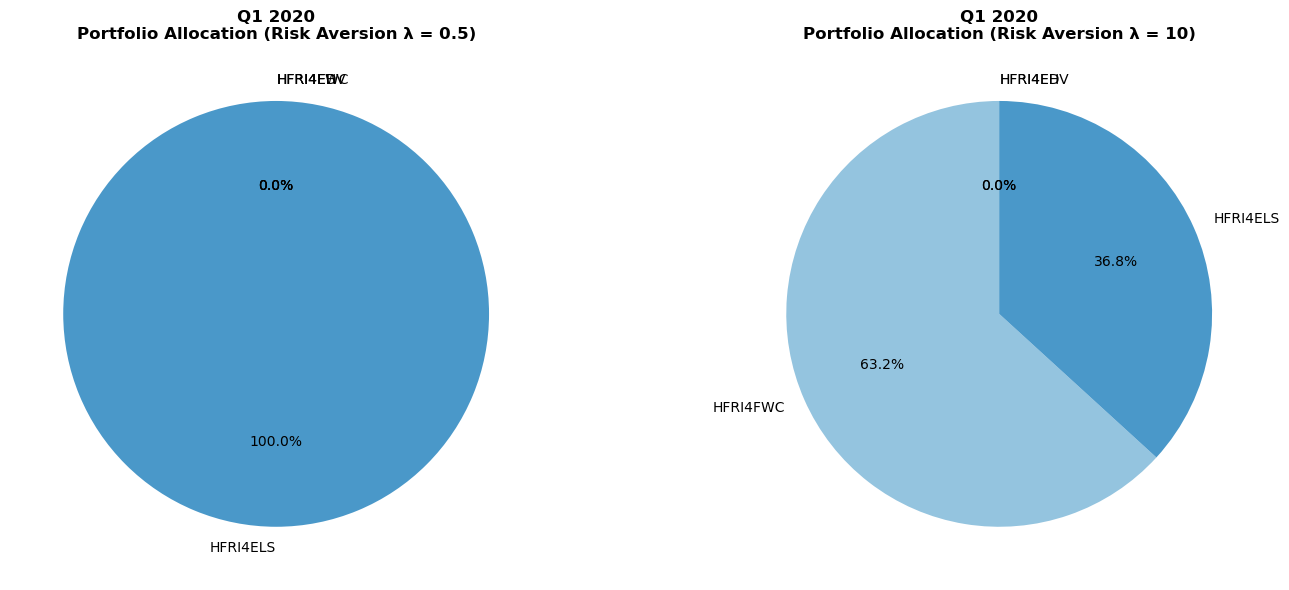

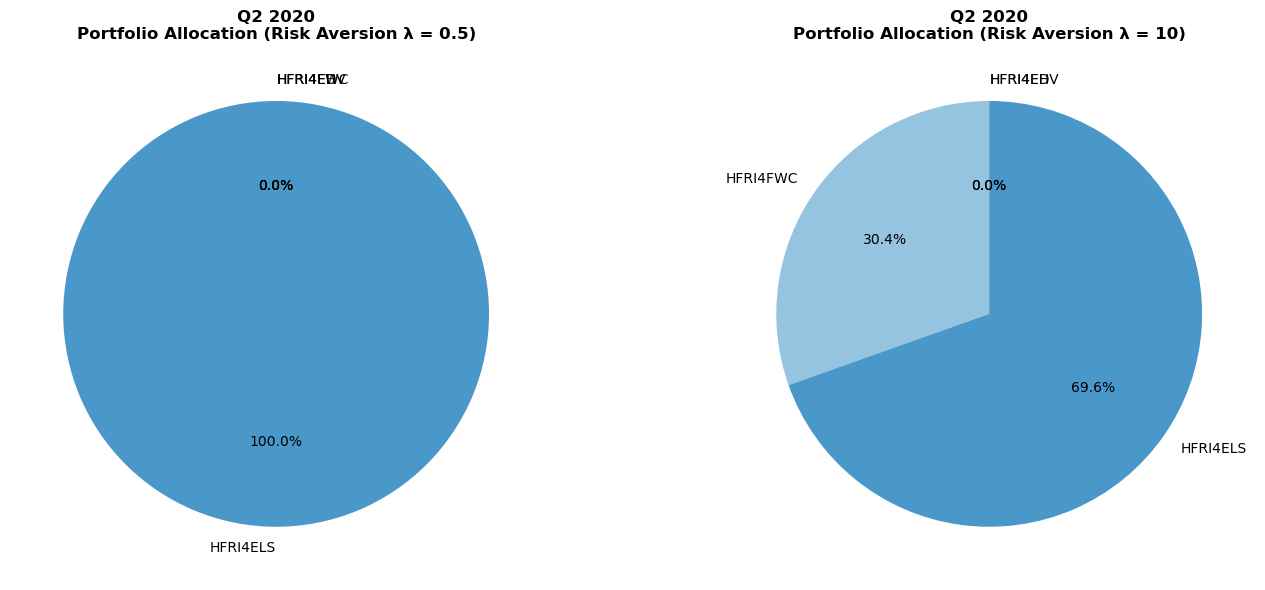

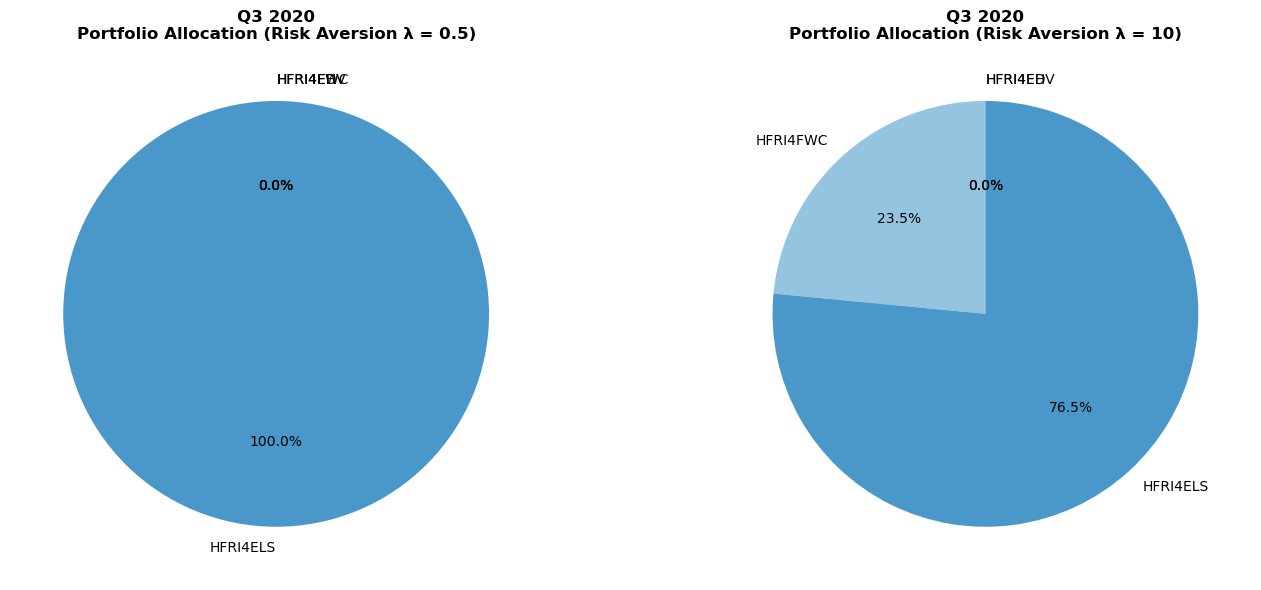

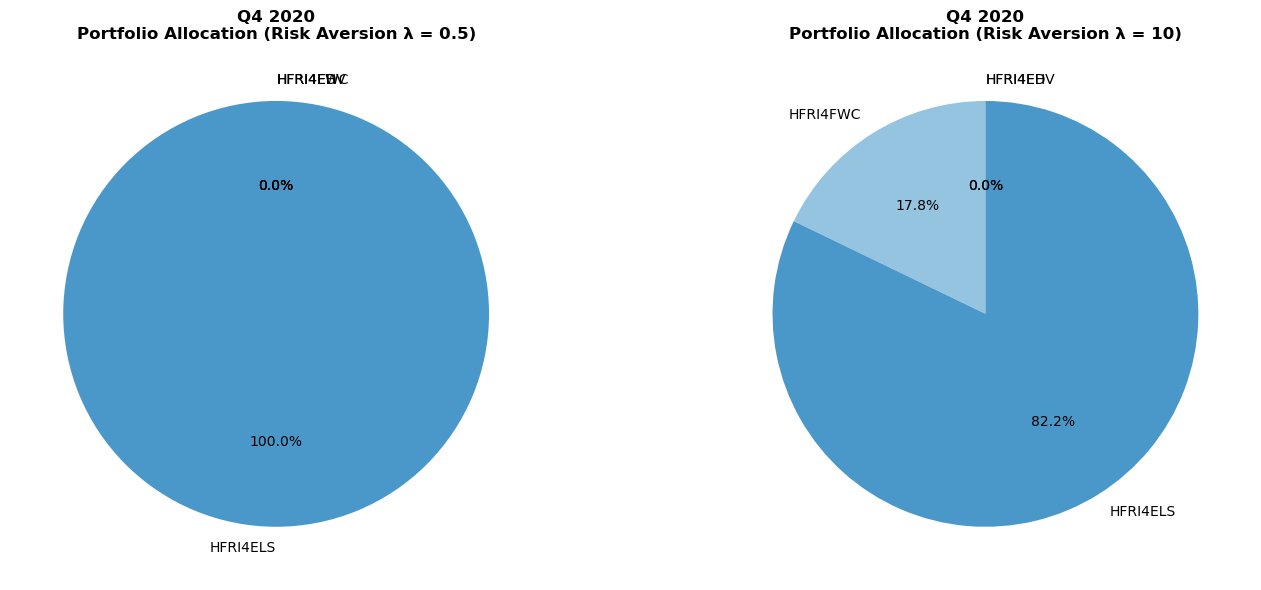

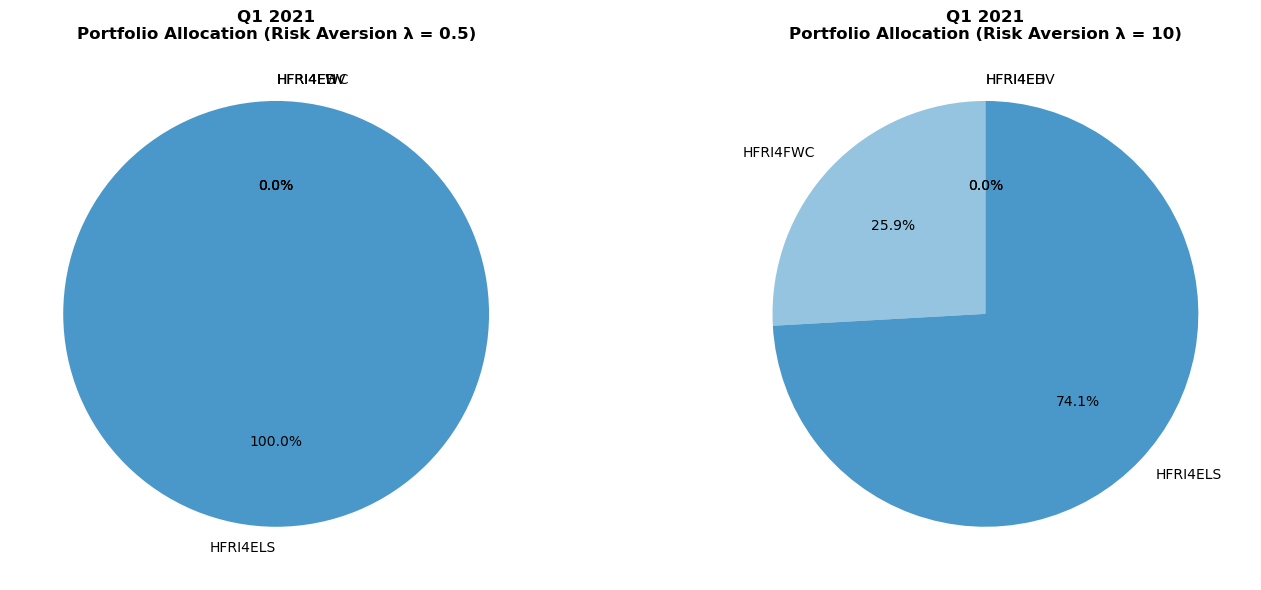

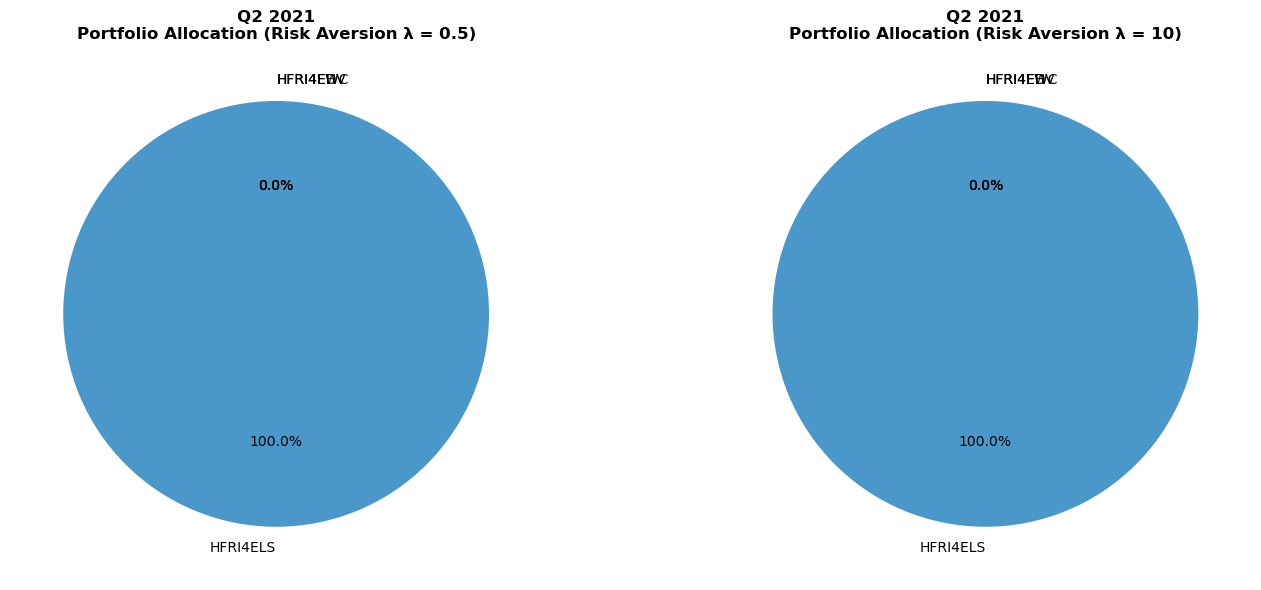

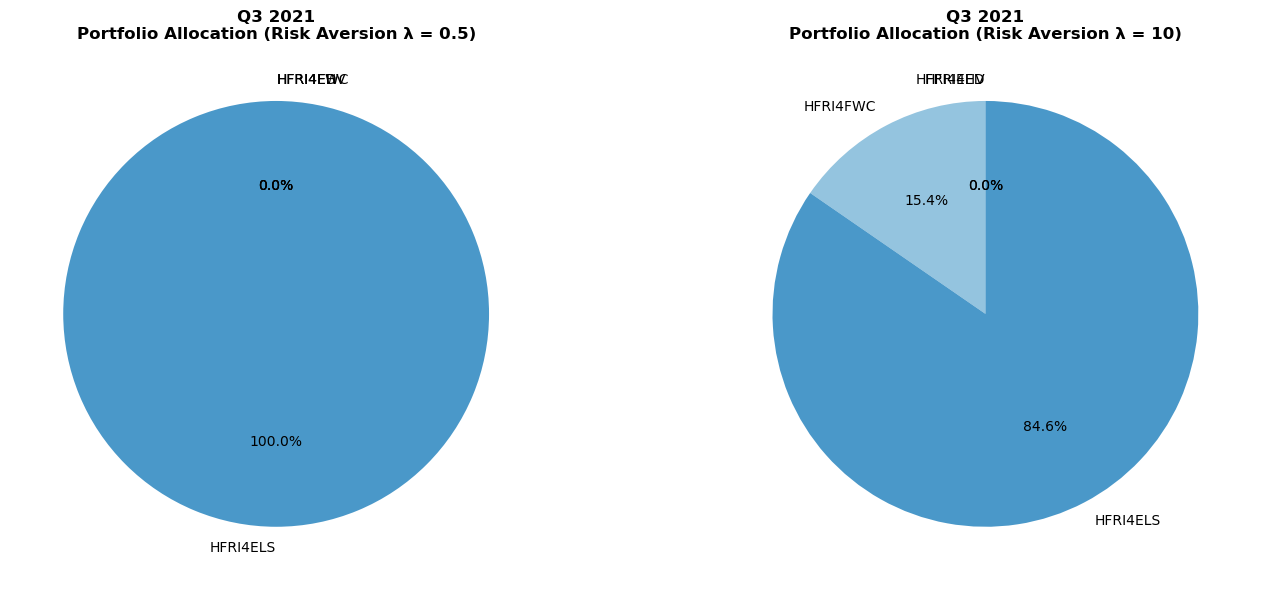

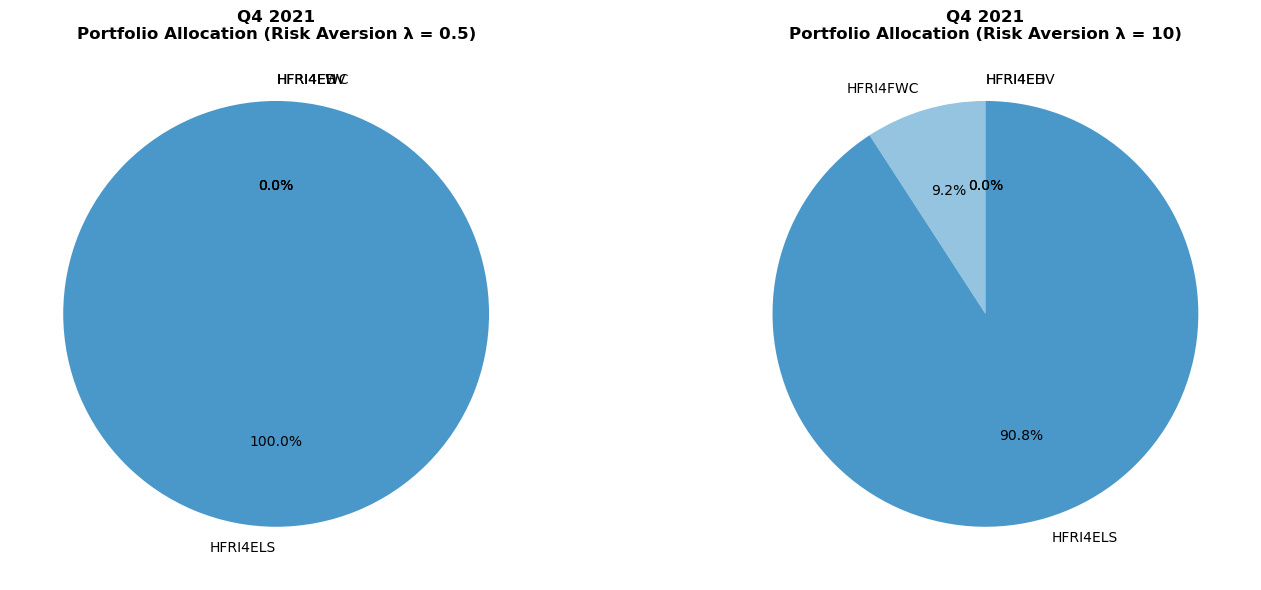

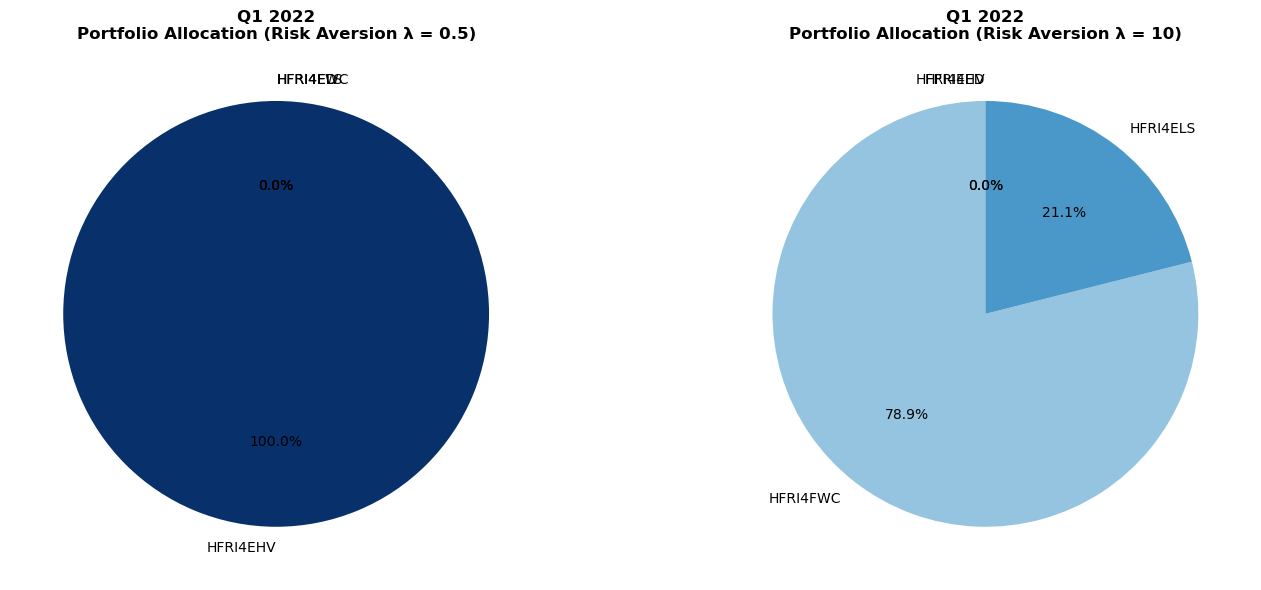

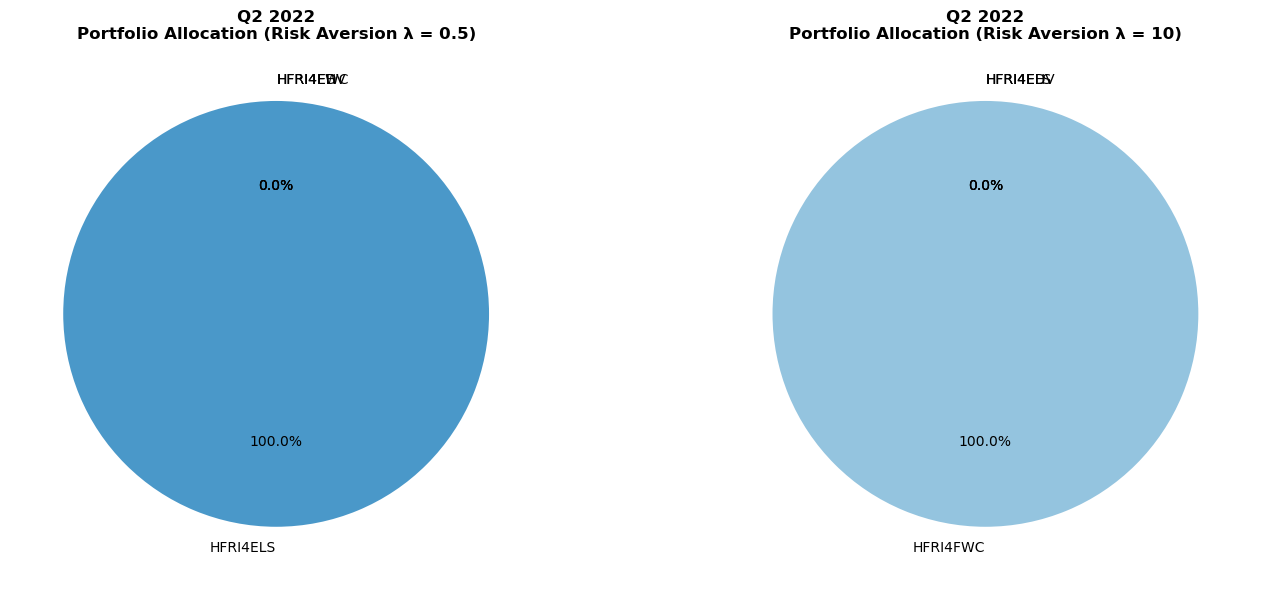

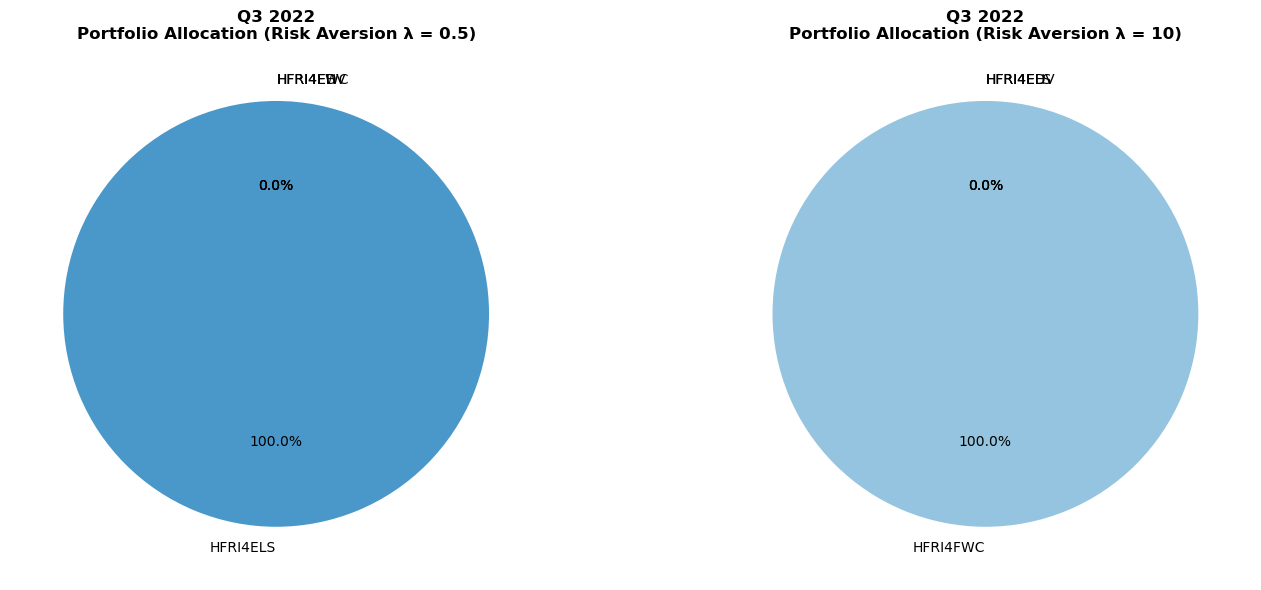

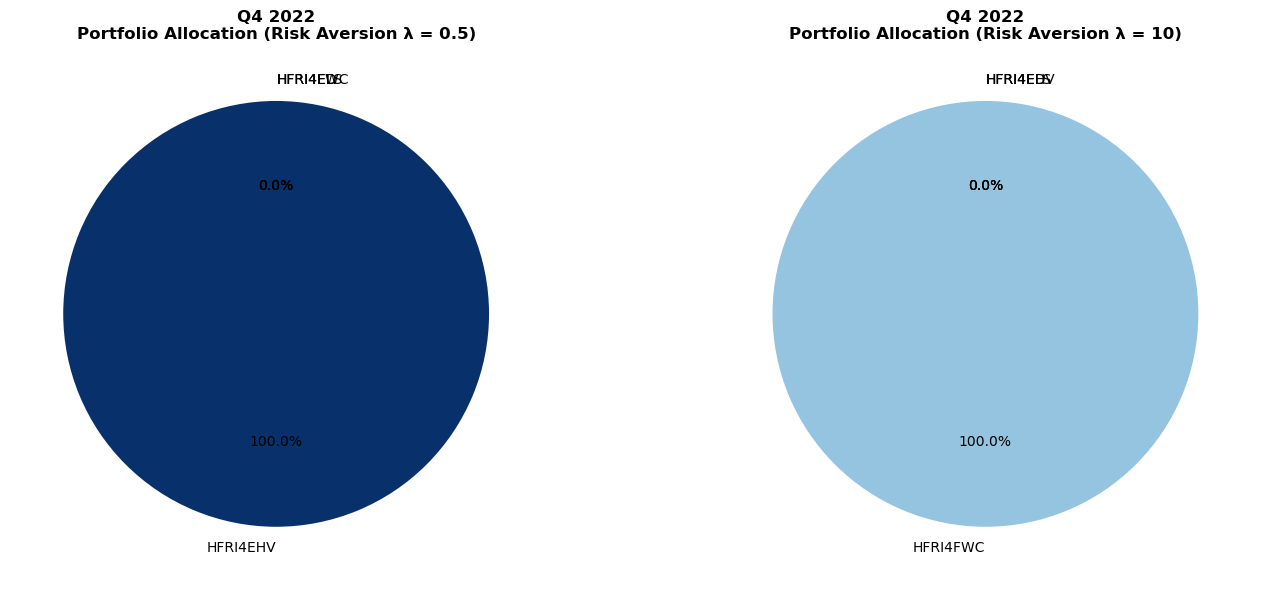

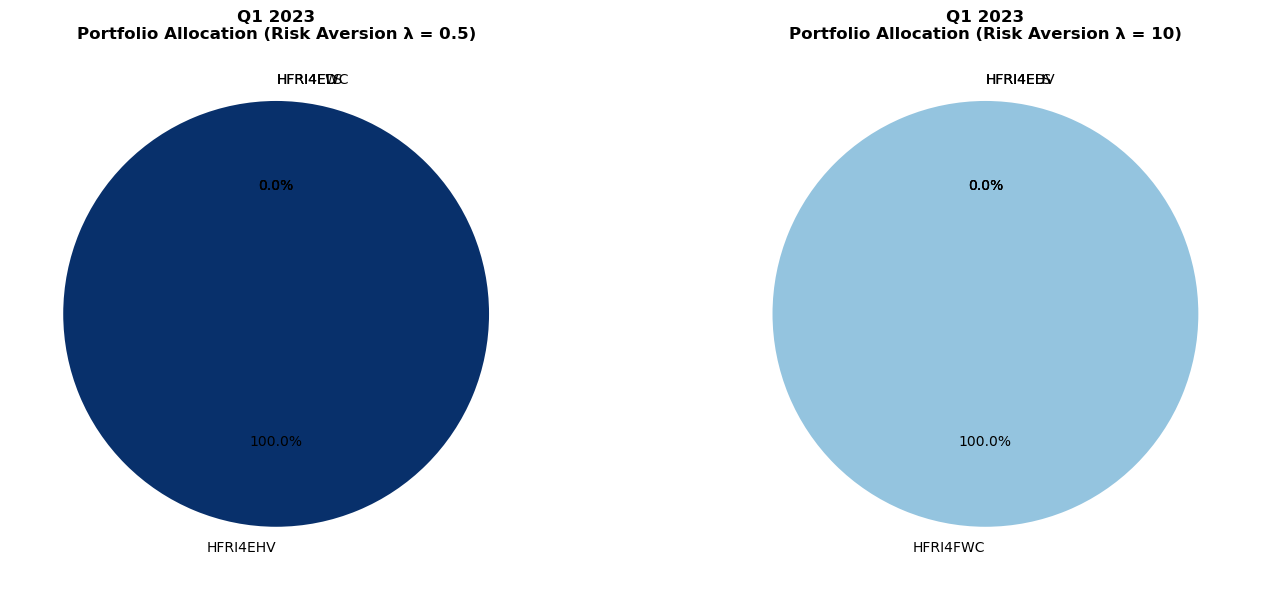

In [27]:
# Get asset names (columns except 'Quarter')
asset_names = [col for col in portfolio_weights_05.columns if col != 'Quarter']

# Generate navy blue gradient colors
cmap = cm.get_cmap('Blues')
num_assets = len(asset_names)
colors = [cmap(0.4 + 0.6 * (i / (num_assets - 1))) for i in range(num_assets)]

# Get all quarters
quarters = portfolio_weights_05['Quarter'].tolist()

# Create pie charts for each quarter
for quarter in quarters:
    # Get data for current quarter
    weights_05_row = portfolio_weights_05[portfolio_weights_05['Quarter'] == quarter]
    weights_10_row = portfolio_weights_10[portfolio_weights_10['Quarter'] == quarter]
    
    if len(weights_05_row) == 0 or len(weights_10_row) == 0:
        continue
    
    # Extract weights (convert percentages to numbers if they're strings)
    weights_05 = []
    weights_10 = []
    
    for asset in asset_names:
        # Handle percentage strings (remove % and convert to float)
        weight_05 = weights_05_row[asset].iloc[0]
        weight_10 = weights_10_row[asset].iloc[0]
        
        if isinstance(weight_05, str) and '%' in weight_05:
            weight_05 = float(weight_05.replace('%', ''))
        weights_05.append(weight_05)
        
        if isinstance(weight_10, str) and '%' in weight_10:
            weight_10 = float(weight_10.replace('%', ''))
        weights_10.append(weight_10)
    
    # Create subplot for this quarter
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Pie chart for λ = 0.5
    axes[0].pie(weights_05, labels=asset_names, autopct='%1.1f%%', 
                startangle=90, colors=colors)
    axes[0].set_title(f'{quarter}\nPortfolio Allocation (Risk Aversion λ = 0.5)', 
                      fontweight='bold')
    
    # Pie chart for λ = 10
    axes[1].pie(weights_10, labels=asset_names, autopct='%1.1f%%', 
                startangle=90, colors=colors)
    axes[1].set_title(f'{quarter}\nPortfolio Allocation (Risk Aversion λ = 10)', 
                      fontweight='bold')
    
    plt.tight_layout()
    plt.show()

# **7. Results and Backtesting**

In [28]:
def calculate_monthly_portfolio_returns():
    """Calculate monthly portfolio returns for both risk aversion levels"""
    
    # Get fund columns (exclude 'Quarter' column)
    fund_columns = [col for col in portfolio_weights_05.columns if col != 'Quarter']
    
    # Create a dictionary to store weights by quarter
    weights_dict_05 = {}
    weights_dict_10 = {}
    
    # Process weights from both DataFrames
    for _, row in portfolio_weights_05.iterrows():
        quarter = row['Quarter']
        weights = []
        for fund in fund_columns:
            weight = row[fund]
            if isinstance(weight, str) and '%' in weight:
                weight = float(weight.replace('%', '')) / 100
            weights.append(weight)
        weights_dict_05[quarter] = weights
    
    for _, row in portfolio_weights_10.iterrows():
        quarter = row['Quarter']
        weights = []
        for fund in fund_columns:
            weight = row[fund]
            if isinstance(weight, str) and '%' in weight:
                weight = float(weight.replace('%', '')) / 100
            weights.append(weight)
        weights_dict_10[quarter] = weights
    
    # Function to get quarter from date
    def get_quarter_from_date(date):
        year = date.year
        quarter_num = (date.month - 1) // 3 + 1
        return f"Q{quarter_num} {year}"
    
    # Calculate monthly returns
    monthly_returns_data = []
    
    for date in hf_df.index:
        quarter = get_quarter_from_date(date)
        
        # Check if we have weights for this quarter
        if quarter in weights_dict_05 and quarter in weights_dict_10:
            # Get monthly returns for all funds
            monthly_fund_returns = hf_df.loc[date, fund_columns].values
            
            # Calculate portfolio returns
            portfolio_return_05 = sum(w * r for w, r in zip(weights_dict_05[quarter], monthly_fund_returns))
            portfolio_return_10 = sum(w * r for w, r in zip(weights_dict_10[quarter], monthly_fund_returns))
            
            # Multiply by 100 to get percentage returns
            monthly_returns_data.append({
                'Date': date,
                'Risk_Aversion_05': portfolio_return_05,
                'Risk_Aversion_10': portfolio_return_10
            })
    
    # Create DataFrame
    df_monthly_returns = pd.DataFrame(monthly_returns_data)
    df_monthly_returns.set_index('Date', inplace=True)
    
    return df_monthly_returns

In [29]:
# Calculate monthly returns
df_monthly_returns = calculate_monthly_portfolio_returns()
print(f"Total months processed: {len(df_monthly_returns)}")

# Display first few rows
print("\nFirst 10 rows of monthly returns:")
print(df_monthly_returns.head(10))

Total months processed: 135

First 10 rows of monthly returns:
            Risk_Aversion_05  Risk_Aversion_10
Date                                          
2012-01-31            0.0351          0.022500
2012-02-29            0.0311          0.019300
2012-03-30            0.0012         -0.000800
2012-04-30           -0.0055         -0.002300
2012-05-31           -0.0445         -0.021500
2012-06-29            0.0079          0.001000
2012-07-31            0.0045          0.011400
2012-08-31            0.0106          0.006700
2012-09-28            0.0197          0.009700
2012-10-31            0.0080          0.003985


In [30]:
# First, let's check what type of data we actually have
print("Data types:")
print(df_monthly_returns.dtypes)
print("\nFirst few rows:")
print(df_monthly_returns.head())
print("\nSample values:")
print("Risk_Aversion_05 sample:", df_monthly_returns['Risk_Aversion_05'].iloc[0])
print("Type:", type(df_monthly_returns['Risk_Aversion_05'].iloc[0]))

Data types:
Risk_Aversion_05    float64
Risk_Aversion_10    float64
dtype: object

First few rows:
            Risk_Aversion_05  Risk_Aversion_10
Date                                          
2012-01-31            0.0351            0.0225
2012-02-29            0.0311            0.0193
2012-03-30            0.0012           -0.0008
2012-04-30           -0.0055           -0.0023
2012-05-31           -0.0445           -0.0215

Sample values:
Risk_Aversion_05 sample: 0.0351
Type: <class 'numpy.float64'>


<Figure size 1500x600 with 0 Axes>

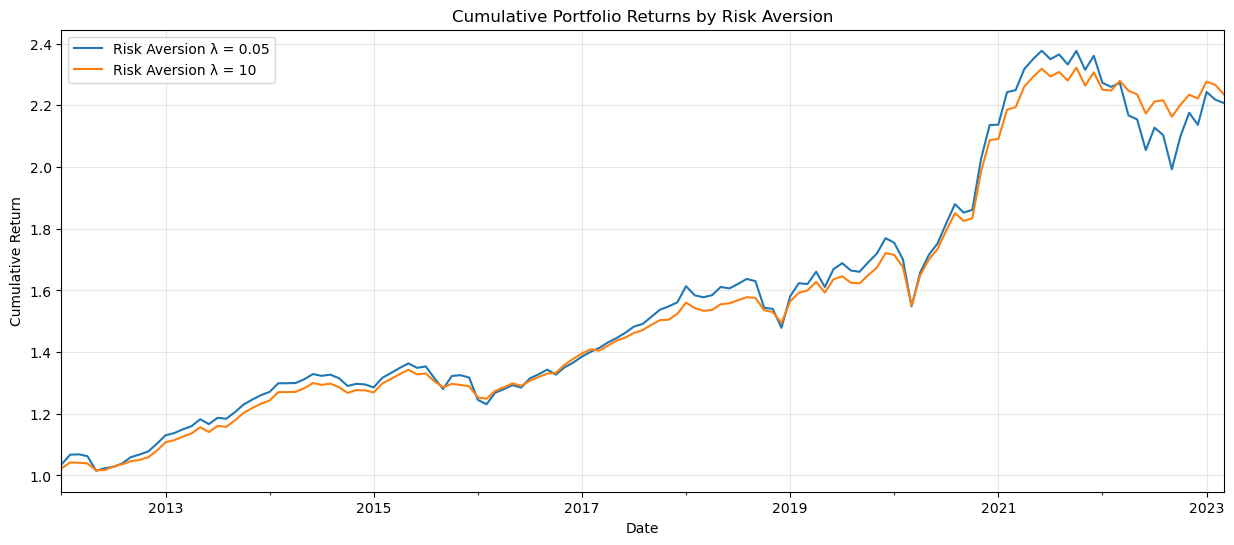


Cumulative return stats:
Risk Aversion 0.05 - Final cumulative return: 2.2076
Risk Aversion 10 - Final cumulative return: 2.2354
            Risk_Aversion_05  Risk_Aversion_10
Date                                          
2012-01-31          1.035100          1.022500
2012-02-29          1.067292          1.042234
2012-03-30          1.068572          1.041400
2012-04-30          1.062695          1.039005
2012-05-31          1.015405          1.016667


In [31]:
df_monthly_returns_numeric = df_monthly_returns.copy()

asset_cum_returns = (1 + df_monthly_returns_numeric).cumprod()

plt.figure(figsize=(15, 6))
asset_cum_returns.plot(figsize=(15, 6), title='Cumulative Portfolio Returns by Risk Aversion')
plt.ylabel('Cumulative Return')
plt.xlabel('Date')
plt.legend(['Risk Aversion λ = 0.05', 'Risk Aversion λ = 10'])
plt.grid(True, alpha=0.3)
plt.show()

print(f"\nCumulative return stats:")
print(f"Risk Aversion 0.05 - Final cumulative return: {asset_cum_returns['Risk_Aversion_05'].iloc[-1]:.4f}")
print(f"Risk Aversion 10 - Final cumulative return: {asset_cum_returns['Risk_Aversion_10'].iloc[-1]:.4f}")

print(asset_cum_returns.head())

In [32]:
asset_perf = pd.DataFrame(dtype = float, columns = ['return','vol','Sharpe','Max Drawdown'])
# calculate performance
asset_perf['return'] = (asset_cum_returns.iloc[-1] ** (1/(asset_cum_returns.shape[0]/12)) - 1) * 100
asset_perf['vol'] = df_monthly_returns.std() * np.sqrt(12) * 100
asset_perf['Sharpe'] = asset_perf['return']/asset_perf['vol']
asset_perf['Max Drawdown'] = (1 - asset_cum_returns/asset_cum_returns.cummax()).max() * 100
asset_perf

,return,vol,Sharpe,Max Drawdown
Risk_Aversion_05,7.292643,8.670005,0.841135,16.171094
Risk_Aversion_10,7.412334,6.420927,1.154402,9.879349
